<a href="https://colab.research.google.com/github/snehamartin30/Assignment-/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
covid_file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
influenza_file_path = '/content/drive/My Drive/FINAL PROJECT/influenza_data.csv'
socioeconomic_file_path = '/content/drive/My Drive/FINAL PROJECT/socioeconomic_data.csv'
healthcare_data = '/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv'

In [ ]:
#Preprocess Each Dataset with Imputation

def impute_with_sampling(df, column):
    non_zero_non_na_values = df.loc[(df[column] != 0) & (~df[column].isna()), column]
    df.loc[df[column].isna() | (df[column] == 0), column] = np.random.choice(non_zero_non_na_values, size=df.loc[df[column].isna() | (df[column] == 0), column].shape[0], replace=True)
    return df


In [ ]:
#PREPROCESSING COVID DATA

# Load the CSV file
file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
covid_data = pd.read_csv(file_path)

# Convert the 'date' column to datetime format
covid_data['date'] = pd.to_datetime(covid_data['date'], errors='coerce')

# Sort the data by location and date
covid_data.sort_values(by=['location', 'date'], inplace=True)

# Compute the 7-day rolling average for relevant columns within each location
# Identify numeric columns
numeric_columns = covid_data.select_dtypes(include=['number']).columns

for column in ['new_cases', 'new_deaths']:
    if column in numeric_columns:
        covid_data[f'{column}_7d_avg'] = covid_data.groupby('location')[column].rolling(window=7).mean().reset_index(0, drop=True)

# Resample the data on a weekly basis for each location, using Sunday as the end of the week
weekly_data = covid_data.groupby('location').resample('W-SUN', on='date').mean(numeric_only=True).reset_index()

# Include the 'location' column in the weekly data
weekly_data = weekly_data[['location', 'date'] + [col for col in weekly_data.columns if col not in ['location', 'date']]]

# Save the weekly data to a new CSV file
weekly_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/weekly_covid_data.csv', index=False)

print("Weekly data with 7-day rolling averages and location has been saved to 'weekly_covid_data.csv'")

Weekly data with 7-day rolling averages and location has been saved to 'weekly_covid_data.csv'


In [ ]:
#PREPROCESSING WEEKLY_COVID_DATA

# Load the CSV file
file_path = '/content/drive/MyDrive/FINAL PROJECT/weekly_covid_data.csv'
weekly_covid_data = pd.read_csv(file_path)

# Correct column names based on inspection
weekly_covid_columns_to_keep = ['location','date','total_cases', 'total_deaths','new_cases','new_deaths','reproduction_rate','gdp_per_capita','population','hosp_patients', 'population_density', 'life_expectancy', 'human_development_index']

# Drop unnecessary columns
weekly_covid_data = weekly_covid_data[weekly_covid_columns_to_keep]

# Impute missing or zero values
for column in weekly_covid_columns_to_keep[1:]:
    weekly_covid_data = impute_with_sampling(weekly_covid_data, column)

# Selecting relevant columns
weekly_covid_data_selected = weekly_covid_data[['location','date','total_cases','total_deaths','new_cases','new_deaths','reproduction_rate','gdp_per_capita','population', 'population_density', 'life_expectancy', 'human_development_index']]

print(weekly_covid_data_selected.head())

#print(weekly_covid_data.head())


      location        date  total_cases   total_deaths  new_cases  \
0  Afghanistan  2020-03-01     5.000000  113443.142857   0.714286   
1  Afghanistan  2020-03-08     5.857143     125.428571   0.428571   
2  Afghanistan  2020-03-15    11.857143   26346.857143   1.714286   
3  Afghanistan  2020-03-22    26.428571     131.428571   2.666667   
4  Afghanistan  2020-03-29    78.142857       1.857143  11.428571   

    new_deaths  reproduction_rate  gdp_per_capita  population  \
0     4.857143           1.170000        1803.987  39835428.0   
1     2.857143           0.574286        1803.987  39835428.0   
2     0.142857           0.883333        1803.987  39835428.0   
3  1779.857143           0.942857        1803.987  39835428.0   
4     0.571429           1.510000        1803.987  39835428.0   

   population_density  life_expectancy  human_development_index  
0              54.422            64.83                    0.511  
1              54.422            64.83                    0.51

In [ ]:
#Preprocess Influenza Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/influenza_data.csv'
influenza_data = pd.read_csv(file_path)


# Columns to impute
influenza_columns = ['All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']

# Impute each column
for column in influenza_columns:
    influenza_data = impute_with_sampling(influenza_data, column)

# Selecting relevant columns
influenza_data_selected = influenza_data[['Day', 'All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']]
print(influenza_data_selected.head())


          Day  All strains - All types of surveillance  \
0  2009-09-28                                      3.0   
1  2009-10-05                                      4.0   
2  2009-10-12                                      1.0   
3  2009-10-19                                     98.0   
4  2009-10-26                                     64.0   

   Reported deaths caused by severe acute respiratory infections  \
0                                                1.0               
1                                              174.0               
2                                                2.0               
3                                                1.0               
4                                                2.0               

   Cases of influenza-like illnesses  \
0                               44.0   
1                             1264.0   
2                               30.0   
3                                9.0   
4                           179916.0   

 

In [ ]:
#Preprocess Socioeconomic Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/socioeconomic_data.csv'
socioeconomic_data = pd.read_csv(file_path)
# Columns to impute
socioeconomic_columns = ['Physicians per thousand', 'Latitude']

# Impute each column
for column in socioeconomic_columns:
    socioeconomic_data = impute_with_sampling(socioeconomic_data, column)

# Selecting relevant columns
socioeconomic_data_selected = socioeconomic_data[['Physicians per thousand', 'Latitude']]
print(socioeconomic_data_selected.head())


   Physicians per thousand   Latitude
0                     0.28  33.939110
1                     1.20  41.153332
2                     1.72  28.033886
3                     3.33  42.506285
4                     0.21 -11.202692


In [ ]:
#Preprocess healthcare_data

file_path = '/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv'
healthcare_data = pd.read_csv(file_path)
# Columns to impute
healthcare_columns = ['Country Name', 'Value']

# Impute each column
for column in healthcare_columns:
    healthcare_data = impute_with_sampling(healthcare_data, column)

# Selecting relevant columns
healthcare_data_selected = healthcare_data[['Country Name', 'Value']]
print(healthcare_data_selected.head())


                  Country Name       Value
0                        Aruba  360.334667
1  Africa Eastern and Southern  198.329791
2                  Afghanistan  148.761103
3   Africa Western and Central  127.174353
4                       Angola  177.515341


In [ ]:
#Merge the Datasets

# Concatenate the datasets along columns
merged_data = pd.concat([weekly_covid_data_selected, influenza_data_selected, socioeconomic_data_selected], axis=1)

# Save the merged DataFrame to a CSV file
merged_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/complete_data.csv', index=False)

# Display the first few rows of the merged DataFrame to confirm the merge
print(merged_data.head())

      location        date  total_cases   total_deaths  new_cases  \
0  Afghanistan  2020-03-01     5.000000  113443.142857   0.714286   
1  Afghanistan  2020-03-08     5.857143     125.428571   0.428571   
2  Afghanistan  2020-03-15    11.857143   26346.857143   1.714286   
3  Afghanistan  2020-03-22    26.428571     131.428571   2.666667   
4  Afghanistan  2020-03-29    78.142857       1.857143  11.428571   

    new_deaths  reproduction_rate  gdp_per_capita  population  \
0     4.857143           1.170000        1803.987  39835428.0   
1     2.857143           0.574286        1803.987  39835428.0   
2     0.142857           0.883333        1803.987  39835428.0   
3  1779.857143           0.942857        1803.987  39835428.0   
4     0.571429           1.510000        1803.987  39835428.0   

   population_density  life_expectancy  human_development_index         Day  \
0              54.422            64.83                    0.511  2009-09-28   
1              54.422            64.

In [ ]:
# Load the final merged dataset
# Assuming the dataframe 'merged_data' is already available as shown in your final result

# Check for duplicate columns
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Convert relevant columns to numeric if they are not already
numeric_columns = merged_data.select_dtypes(include=['number']).columns.tolist()
for col in numeric_columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Impute missing values using Iterative Imputer
imputer = IterativeImputer(random_state=0)
imputed_data = imputer.fit_transform(merged_data[numeric_columns])

# Create a DataFrame from the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=numeric_columns)

# Merge non-numeric columns back
non_numeric_columns = merged_data.select_dtypes(exclude=['number'])
final_cleaned_data = pd.concat([non_numeric_columns.reset_index(drop=True), imputed_df], axis=1)

# Display the final cleaned data
print("Final Cleaned Data with Imputed Values:")
print(final_cleaned_data.head())

# Save the final cleaned data to a CSV file
final_cleaned_data.to_csv('/content/drive/My Drive/FINAL PROJECT/final_cleaned_data.csv', index=False)


Final Cleaned Data with Imputed Values:
      location        date         Day  total_cases   total_deaths  new_cases  \
0  Afghanistan  2020-03-01  2009-09-28     5.000000  113443.142857   0.714286   
1  Afghanistan  2020-03-08  2009-10-05     5.857143     125.428571   0.428571   
2  Afghanistan  2020-03-15  2009-10-12    11.857143   26346.857143   1.714286   
3  Afghanistan  2020-03-22  2009-10-19    26.428571     131.428571   2.666667   
4  Afghanistan  2020-03-29  2009-10-26    78.142857       1.857143  11.428571   

    new_deaths  reproduction_rate  gdp_per_capita  population  \
0     4.857143           1.170000        1803.987  39835428.0   
1     2.857143           0.574286        1803.987  39835428.0   
2     0.142857           0.883333        1803.987  39835428.0   
3  1779.857143           0.942857        1803.987  39835428.0   
4     0.571429           1.510000        1803.987  39835428.0   

   population_density  life_expectancy  human_development_index  \
0              

In [ ]:
#EDA
#Summary Statistics and Structure

# Load the preprocessed dataset
file_path = '/content/drive/MyDrive/FINAL PROJECT/final_cleaned_data.csv'  # Adjust the path as needed
df = pd.read_csv(file_path)

# Display the structure and summary statistics
print(df.info())
df.head()
df.isnull().sum()

print(df.describe(include='all'))

df.isnull().sum()

df.drop_duplicates(inplace=True)

df['date'] = pd.to_datetime(df['date'])

df.describe()





<ipython-input-29-976e115e8765>:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142410 entries, 0 to 142409
Data columns (total 19 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   location                                                       23921 non-null   object 
 1   date                                                           23921 non-null   object 
 2   Day                                                            142410 non-null  object 
 3   total_cases                                                    142410 non-null  float64
 4   reproduction_rate                                              142410 non-null  float64
 5   total_deaths                                                   142410 non-null  float64
 6   gdp_per_capita                                                 142410 non-null  float64
 7   new_cases                                      

date   total_cases  reproduction_rate  \
count                          23921  1.424100e+05      142410.000000   
mean   2021-03-10 18:38:50.571464448  2.523067e+06           1.006781   
min              2020-01-05 00:00:00  1.000000e+00          -0.073333   
25%              2020-09-06 00:00:00  2.517399e+06           1.004650   
50%              2021-03-14 00:00:00  2.521044e+06           1.006167   
75%              2021-09-12 00:00:00  2.521562e+06           1.006900   
max              2022-03-06 00:00:00  4.411109e+08           5.490000   
std                              NaN  6.299041e+06           0.148778   

       total_deaths  gdp_per_capita     new_cases     new_deaths  \
count  1.424100e+05   142410.000000  1.424100e+05  142410.000000   
mean   5.612587e+04    19678.432762  1.249034e+04     215.521848   
min    1.000000e+00      661.240000  1.428571e-01       0.142857   
25%    5.607883e+04    19576.742211  1.247411e+04     206.355701   
50%    5.619915e+04    19615.320367  1.251352e+04     215.781221   
75%    5.624032e+04    19695.295096  1.252736e+04     219.752864   
max    5.976714e+06   116935.600000  3.332926e+06   14390.571429   
std    1.203250e+05     8479.276487  3.491491e+04     372.840224   

         population  population_density  life_expectancy  \
count  1.424100e+05       142410.000000    142410.000000   
mean   1.467608e+08          468.441947        73.559231   
min    4.700000e+01            0.137000        53.280000   
25%    1.434238e+08          404.943492        73.508196   
50%    1.449845e+08          433.675084        73.594852   
75%    1.476359e+08          487.216498        73.638864   
max    7.874966e+09        20546.766000        86.750000   
std    2.886669e+08          885.500822         3.073914   

       human_development_index  All strains - All types of surveillance  \
count            142410.000000                            142410.000000   
mean                  0.725611                               372.614212   
min                   0.394000                                 1.000000   
25%                   0.724018                                 3.000000   
50%                   0.726673                                11.000000   
75%                   0.728030                                46.000000   
max                   0.957000                             76691.000000   
std                   0.061558                              2743.782905   

       Reported deaths caused by severe acute respiratory infections  \
count                                      142410.000000               
mean                                          173.654849               
min                                             1.000000               
25%                                             2.000000               
50%                                             8.000000               
75%                                            63.000000               
max                                         12243.000000               
std                                           845.202019               

       Cases of influenza-like illnesses  \
count                      142410.000000   
mean                         8501.824163   
min                             1.000000   
25%                            20.000000   
50%                            94.000000   
75%                           621.000000   
max                        850627.000000   
std                         41145.736655   

       Share of positive tests - All types of surveillance  \
count                                      142410.000000     
mean                                           18.818311     
min                                             0.002040     
25%                                             4.945599     
50%                                            12.689772     
75%                                            26.666666     
max                                           100.000000     
st

In [ ]:
# Define country lists for each category
developed_countries = ['Singapore', 'Bahrain', 'Barbados', 'Mauritius', 'Lebanon', 'South Korea', 'Syria', 'Israel', 'Belgium', 'Japan']
developing_countries = ['Bangladesh', 'Rwanda', 'South Sudan', 'India', 'Haiti', 'Tuvalu', 'Philippines', 'Vietnam', 'El Salvador']
underdeveloped_countries = ['Nigeria', 'Central African Republic']
island_countries = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Saint Lucia', 'Sri Lanka']

# Filter the dataset for each category
developed_df = df[df['location'].isin(developed_countries)]
developing_df = df[df['location'].isin(developing_countries)]
underdeveloped_df = df[df['location'].isin(underdeveloped_countries)]
island_df = df[df['location'].isin(island_countries)]


In [ ]:

# Summary statistics
def summary_statistics(data, title):
    if not data.empty:
        print(f"Summary Statistics for {title}:")
        print(data.describe())
        print("\n")
    else:
        print(f"No data available for {title}")

summary_statistics(developed_df, 'Developed Countries')
summary_statistics(developing_df, 'Developing Countries')
summary_statistics(underdeveloped_df, 'Underdeveloped Countries')
summary_statistics(island_df, 'Island Countries')


Summary Statistics for Developed Countries:
                                date   total_cases  reproduction_rate  \
count                           1071  1.071000e+03        1071.000000   
mean   2021-02-27 07:41:10.588235520  3.331157e+05           1.031401   
min              2020-01-26 00:00:00  1.000000e+00           0.020000   
25%              2020-08-23 00:00:00  6.198000e+03           0.821429   
50%              2021-02-28 00:00:00  5.969014e+04           1.020000   
75%              2021-09-05 00:00:00  3.895810e+05           1.212143   
max              2022-03-06 00:00:00  5.175656e+06           5.490000   
std                              NaN  6.219886e+05           0.413507   

        total_deaths  gdp_per_capita      new_cases   new_deaths  \
count    1071.000000     1071.000000    1071.000000  1071.000000   
mean     4957.281253    35190.167819    2827.643031    42.108410   
min         1.000000      702.225000       0.142857     0.142857   
25%        38.000000    16

<ipython-input-30-922dd30ef68d>:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/final_cleaned_data.csv')


Explained variance by each PC:  [2.80855228e-01 1.47206894e-01 8.37365257e-02 8.06853135e-02
 6.82325756e-02 6.27680741e-02 6.05081871e-02 5.51464200e-02
 4.34765225e-02 2.98951989e-02 2.79849125e-02 2.46419161e-02
 1.98006472e-02 1.50282396e-02 3.29309975e-05 4.14863347e-07]


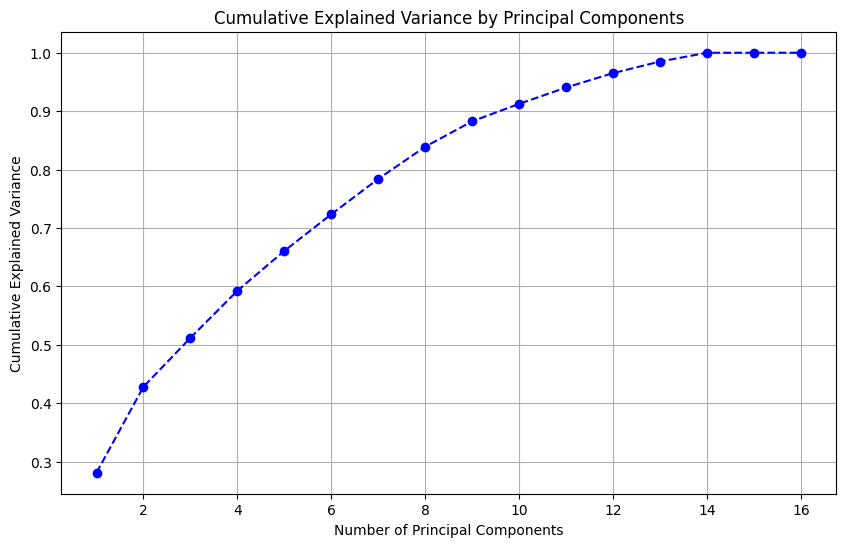

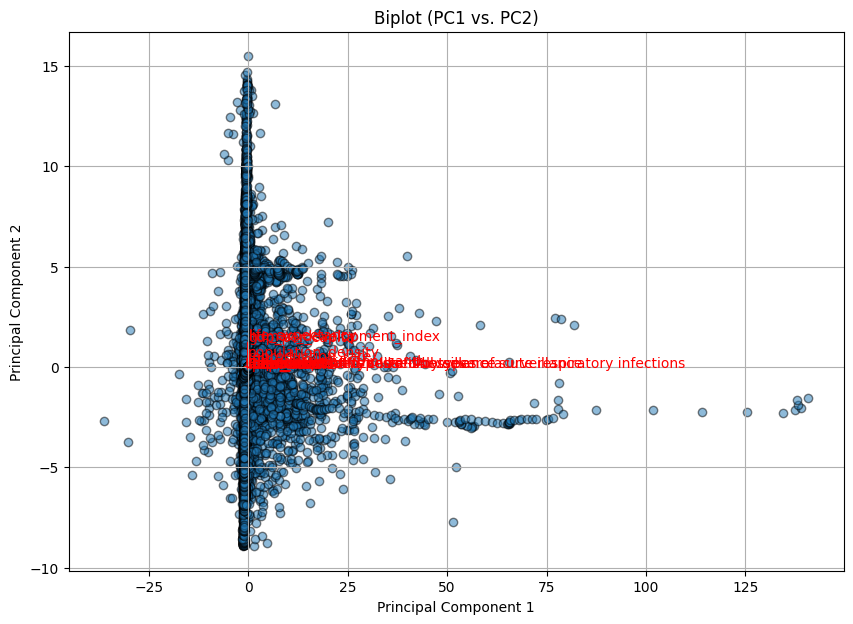

In [ ]:
# Load the data
merged_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/final_cleaned_data.csv')
# Drop any non-numeric columns if necessary (like country names)
numeric_data = merged_data.select_dtypes(include=[np.number])
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
from sklearn.decomposition import PCA

# Initialize PCA with a number of components (e.g., retain as many as you have, or limit to a specific number)
pca = PCA(n_components=None)  # n_components=None will keep all components
principal_components = pca.fit_transform(scaled_data)

# Explained variance by each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance by each PC: ", explained_variance_ratio)


# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance,
         marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components,
                            columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Biplot for PC1 and PC2
plt.figure(figsize=(10, 7))

# Scatter plot of the first two PCs
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5, edgecolor='k')

# Plot vectors for each original feature
feature_vectors = pca.components_.T
arrow_size = 2.0
for i, feature in enumerate(numeric_data.columns):
    plt.arrow(0, 0, arrow_size * feature_vectors[i, 0], arrow_size * feature_vectors[i, 1],
              color='r', head_width=0.05, head_length=0.1)
    plt.text(arrow_size * feature_vectors[i, 0] * 1.2,
             arrow_size * feature_vectors[i, 1] * 1.2,
             feature, color='r')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot (PC1 vs. PC2)')
plt.grid(True)
plt.show()



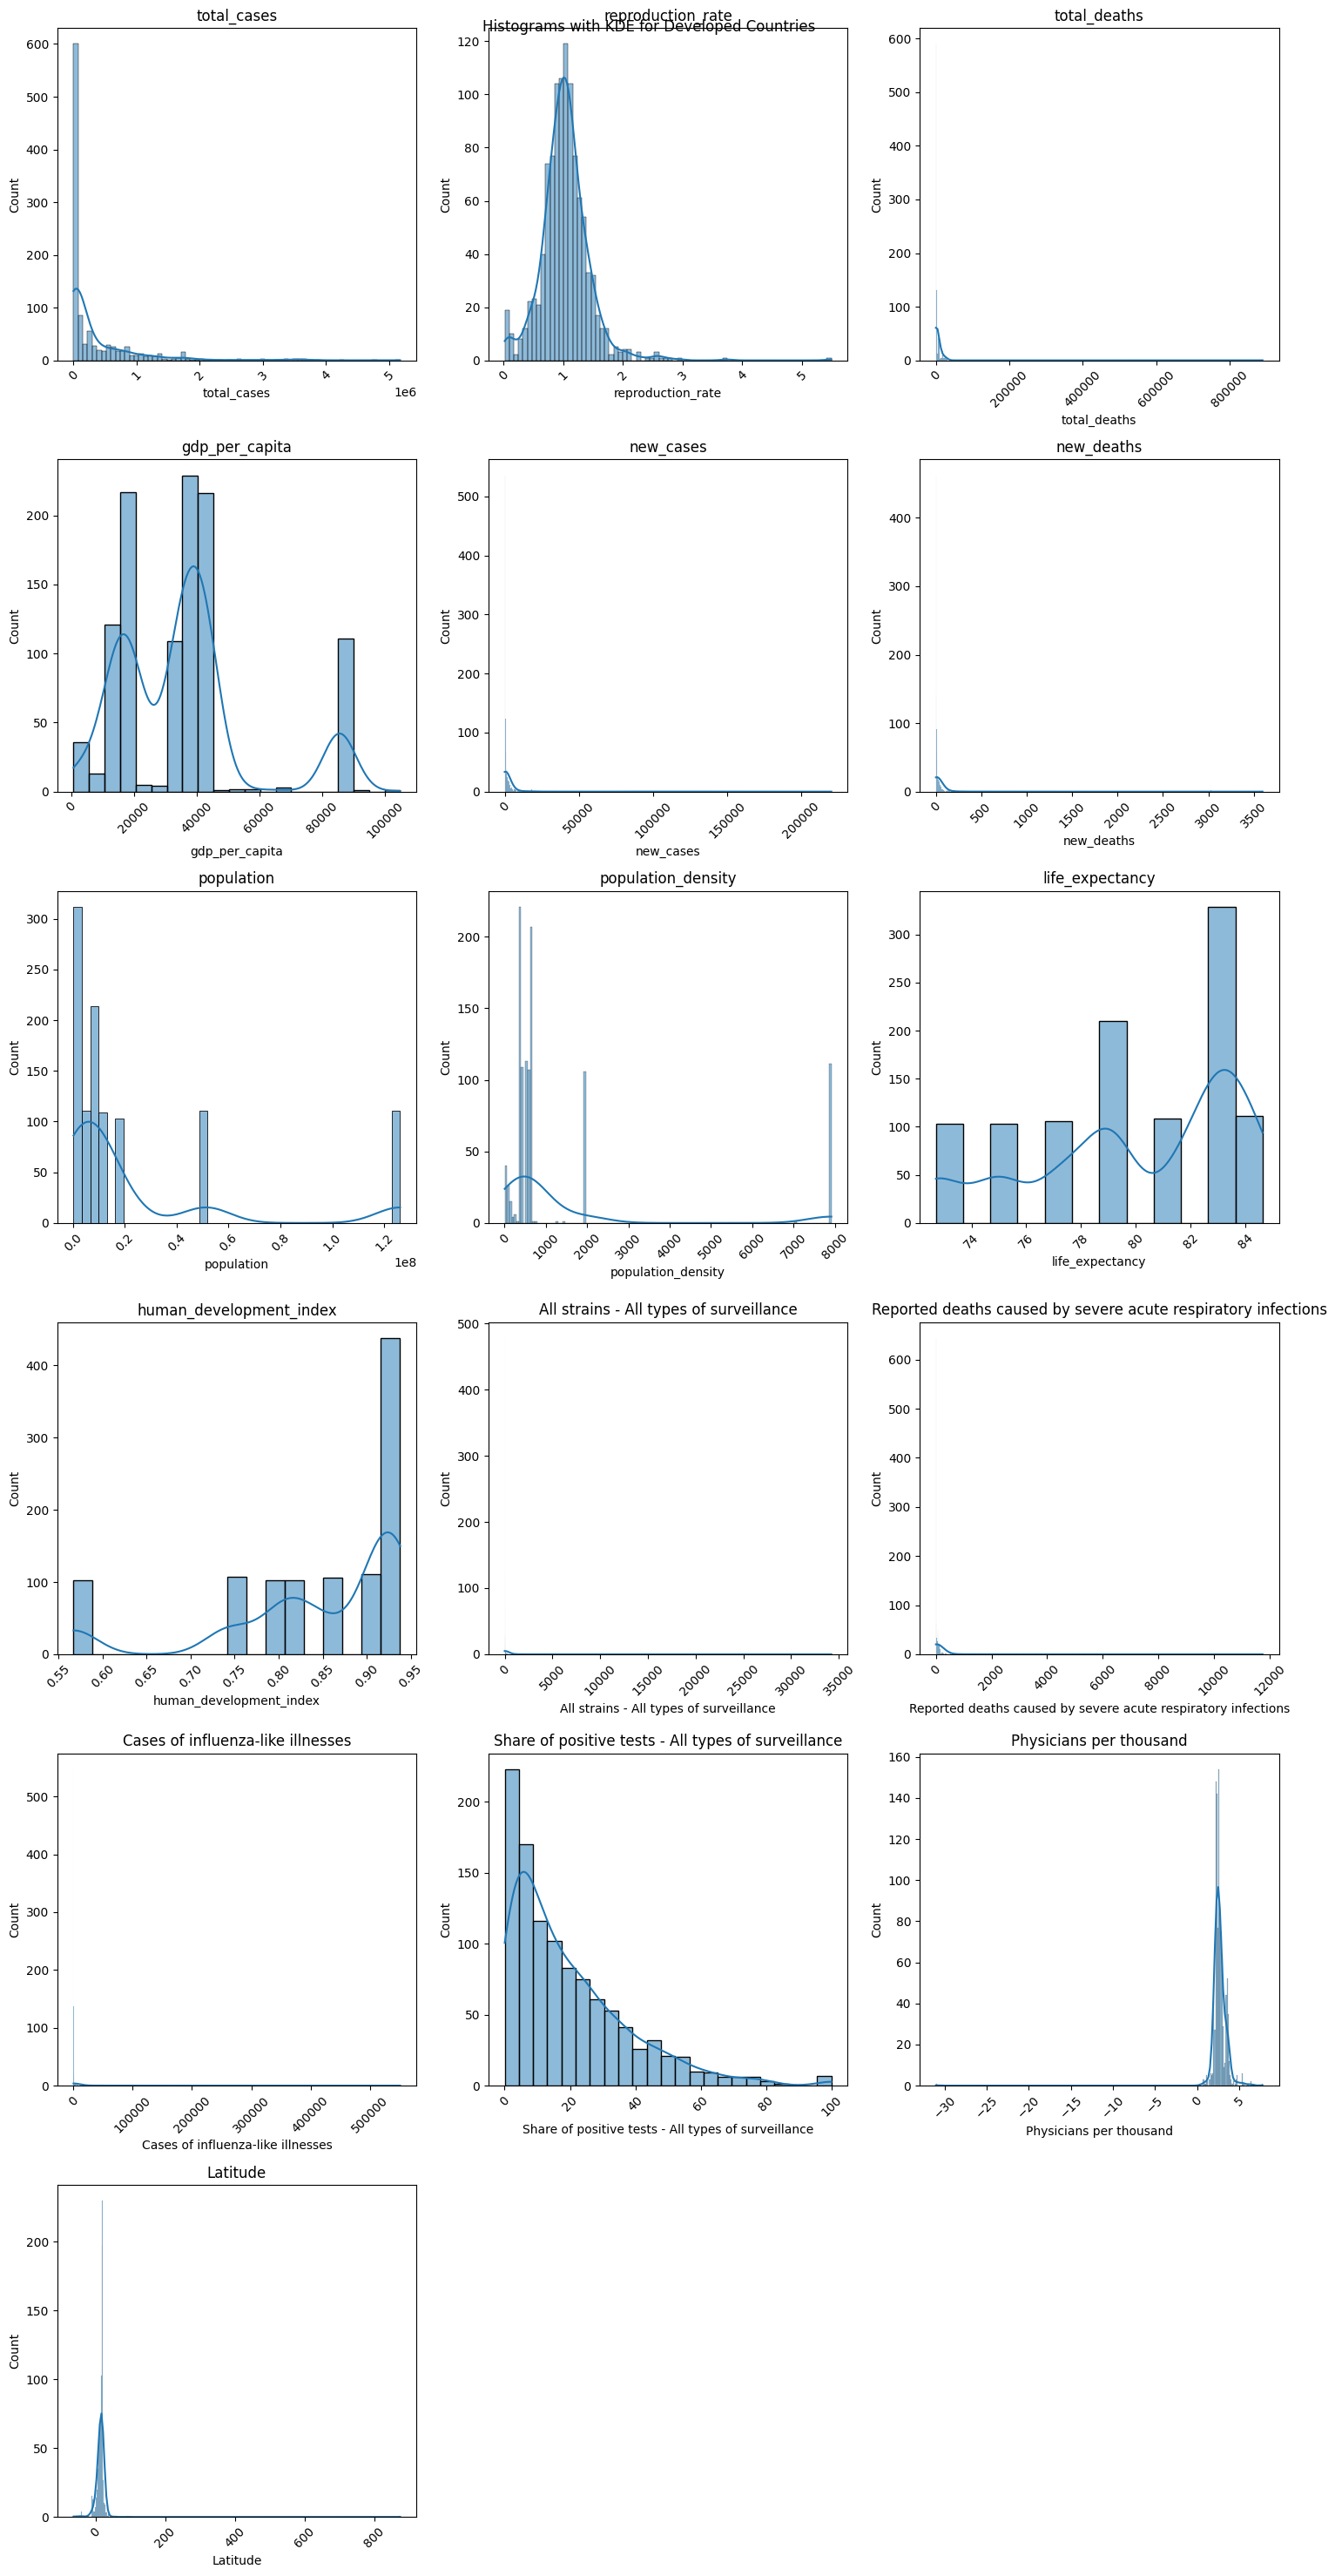

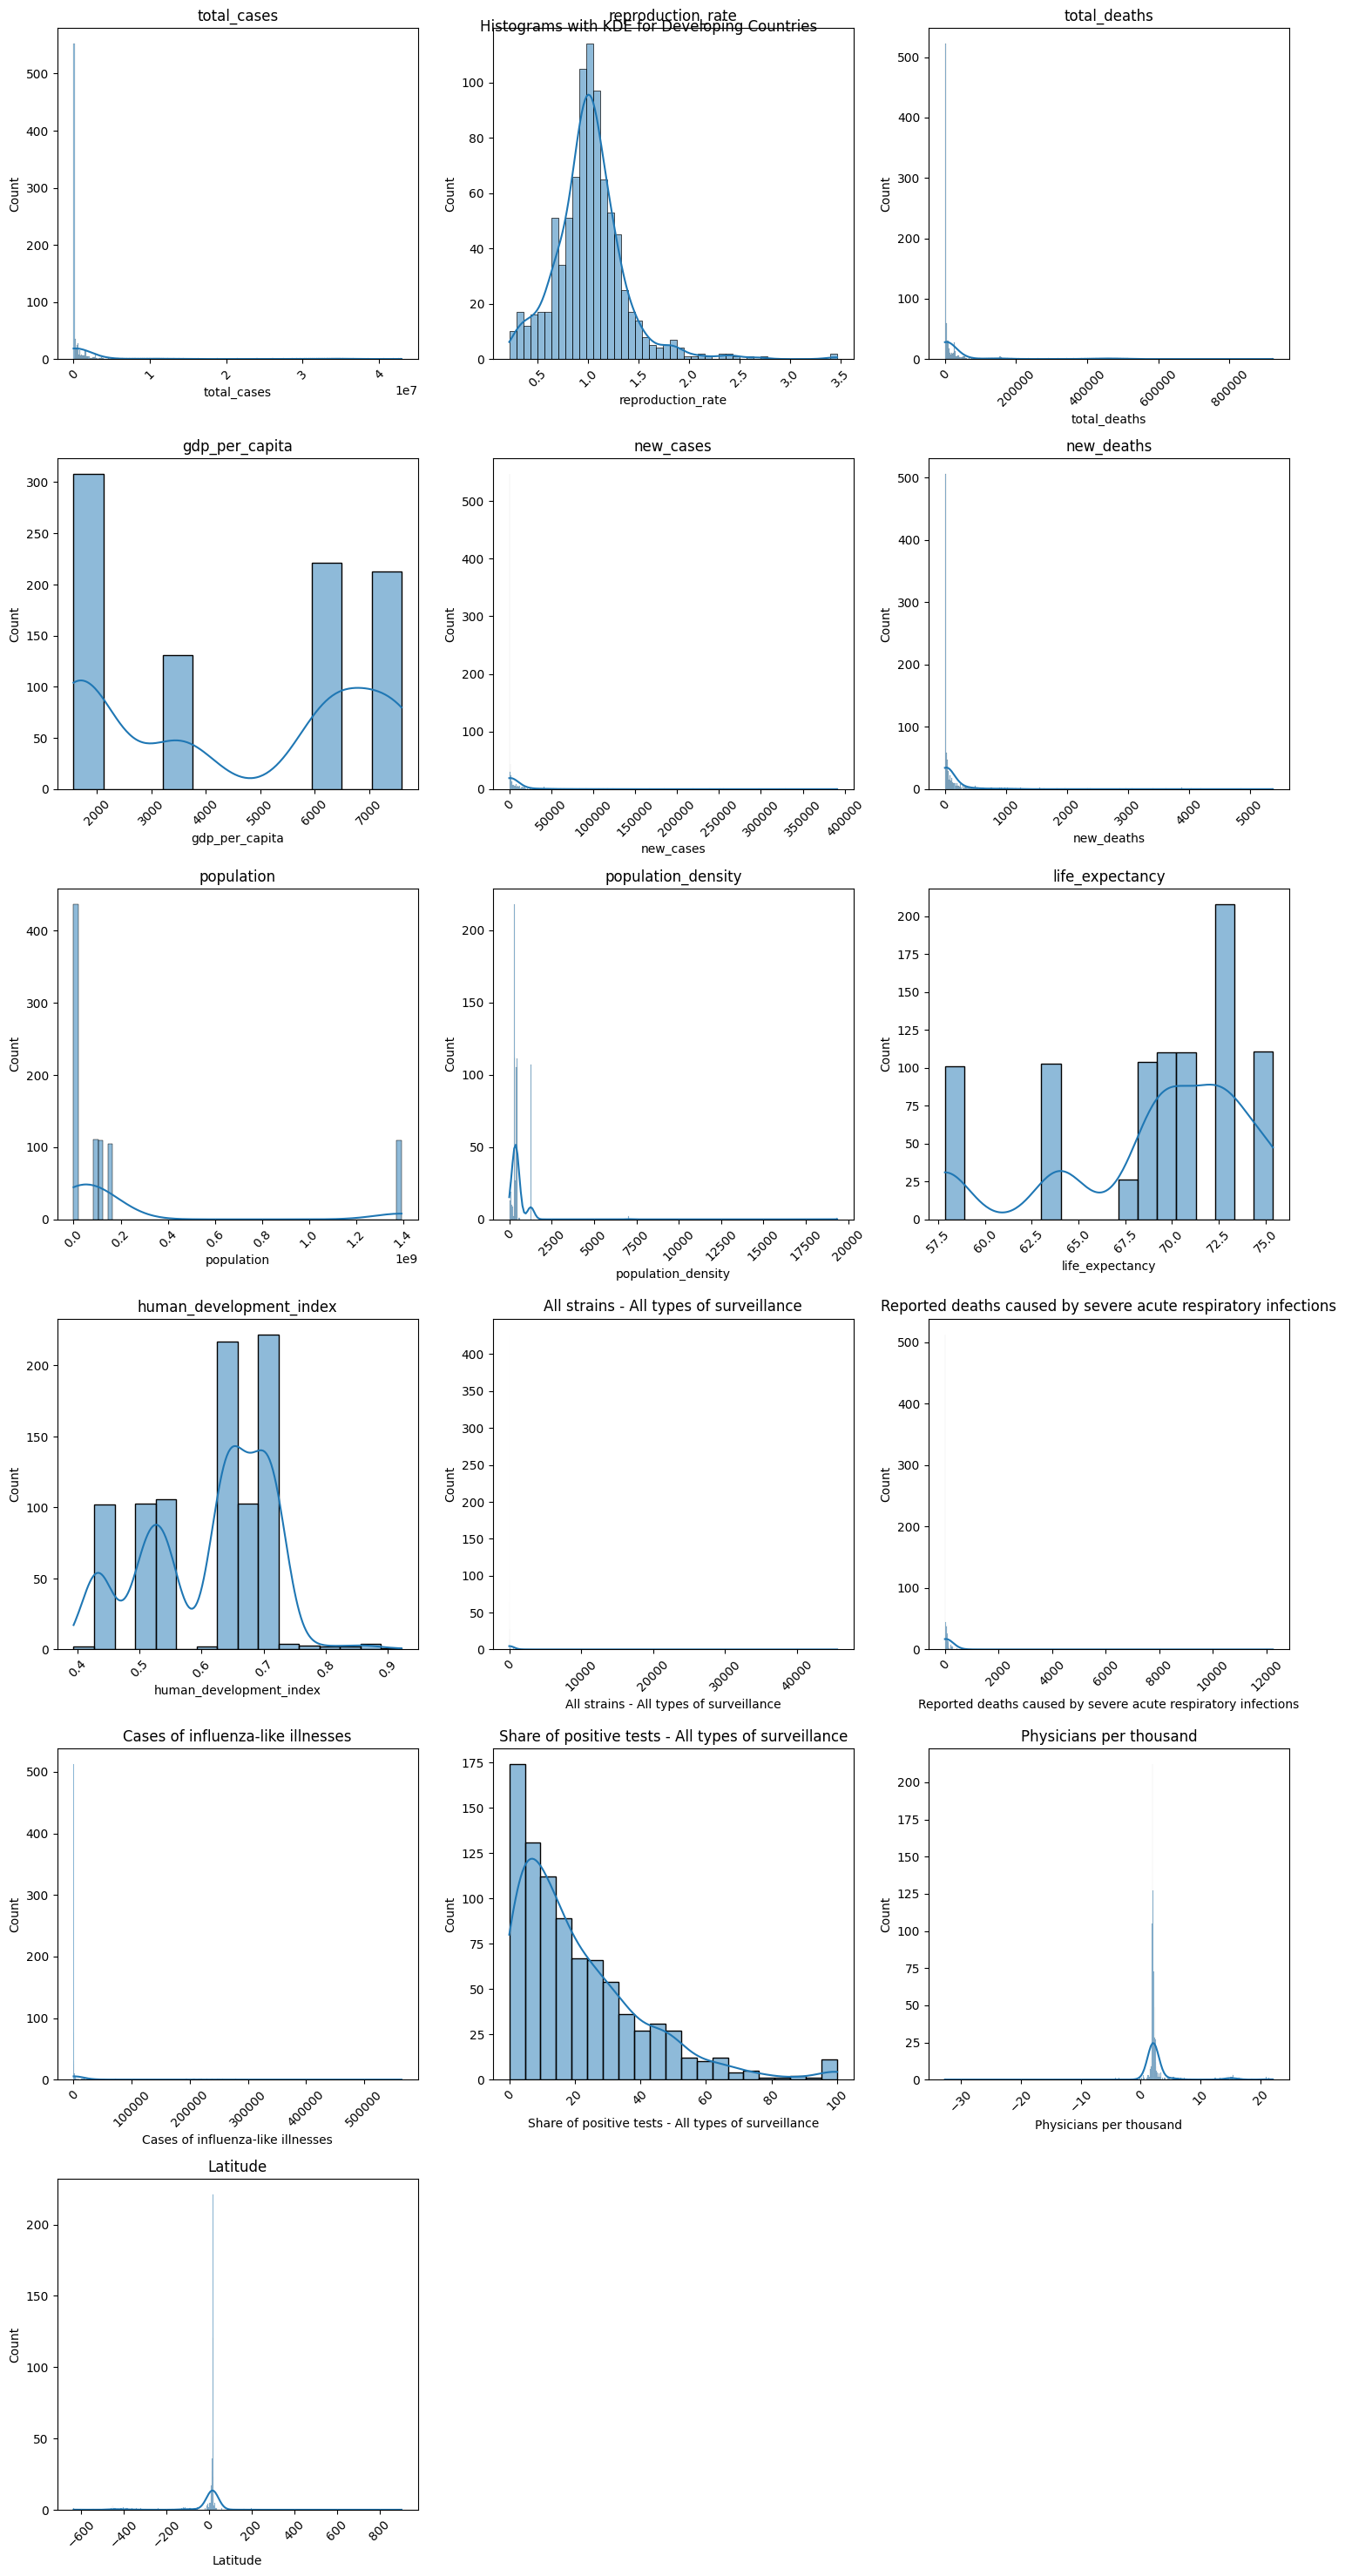

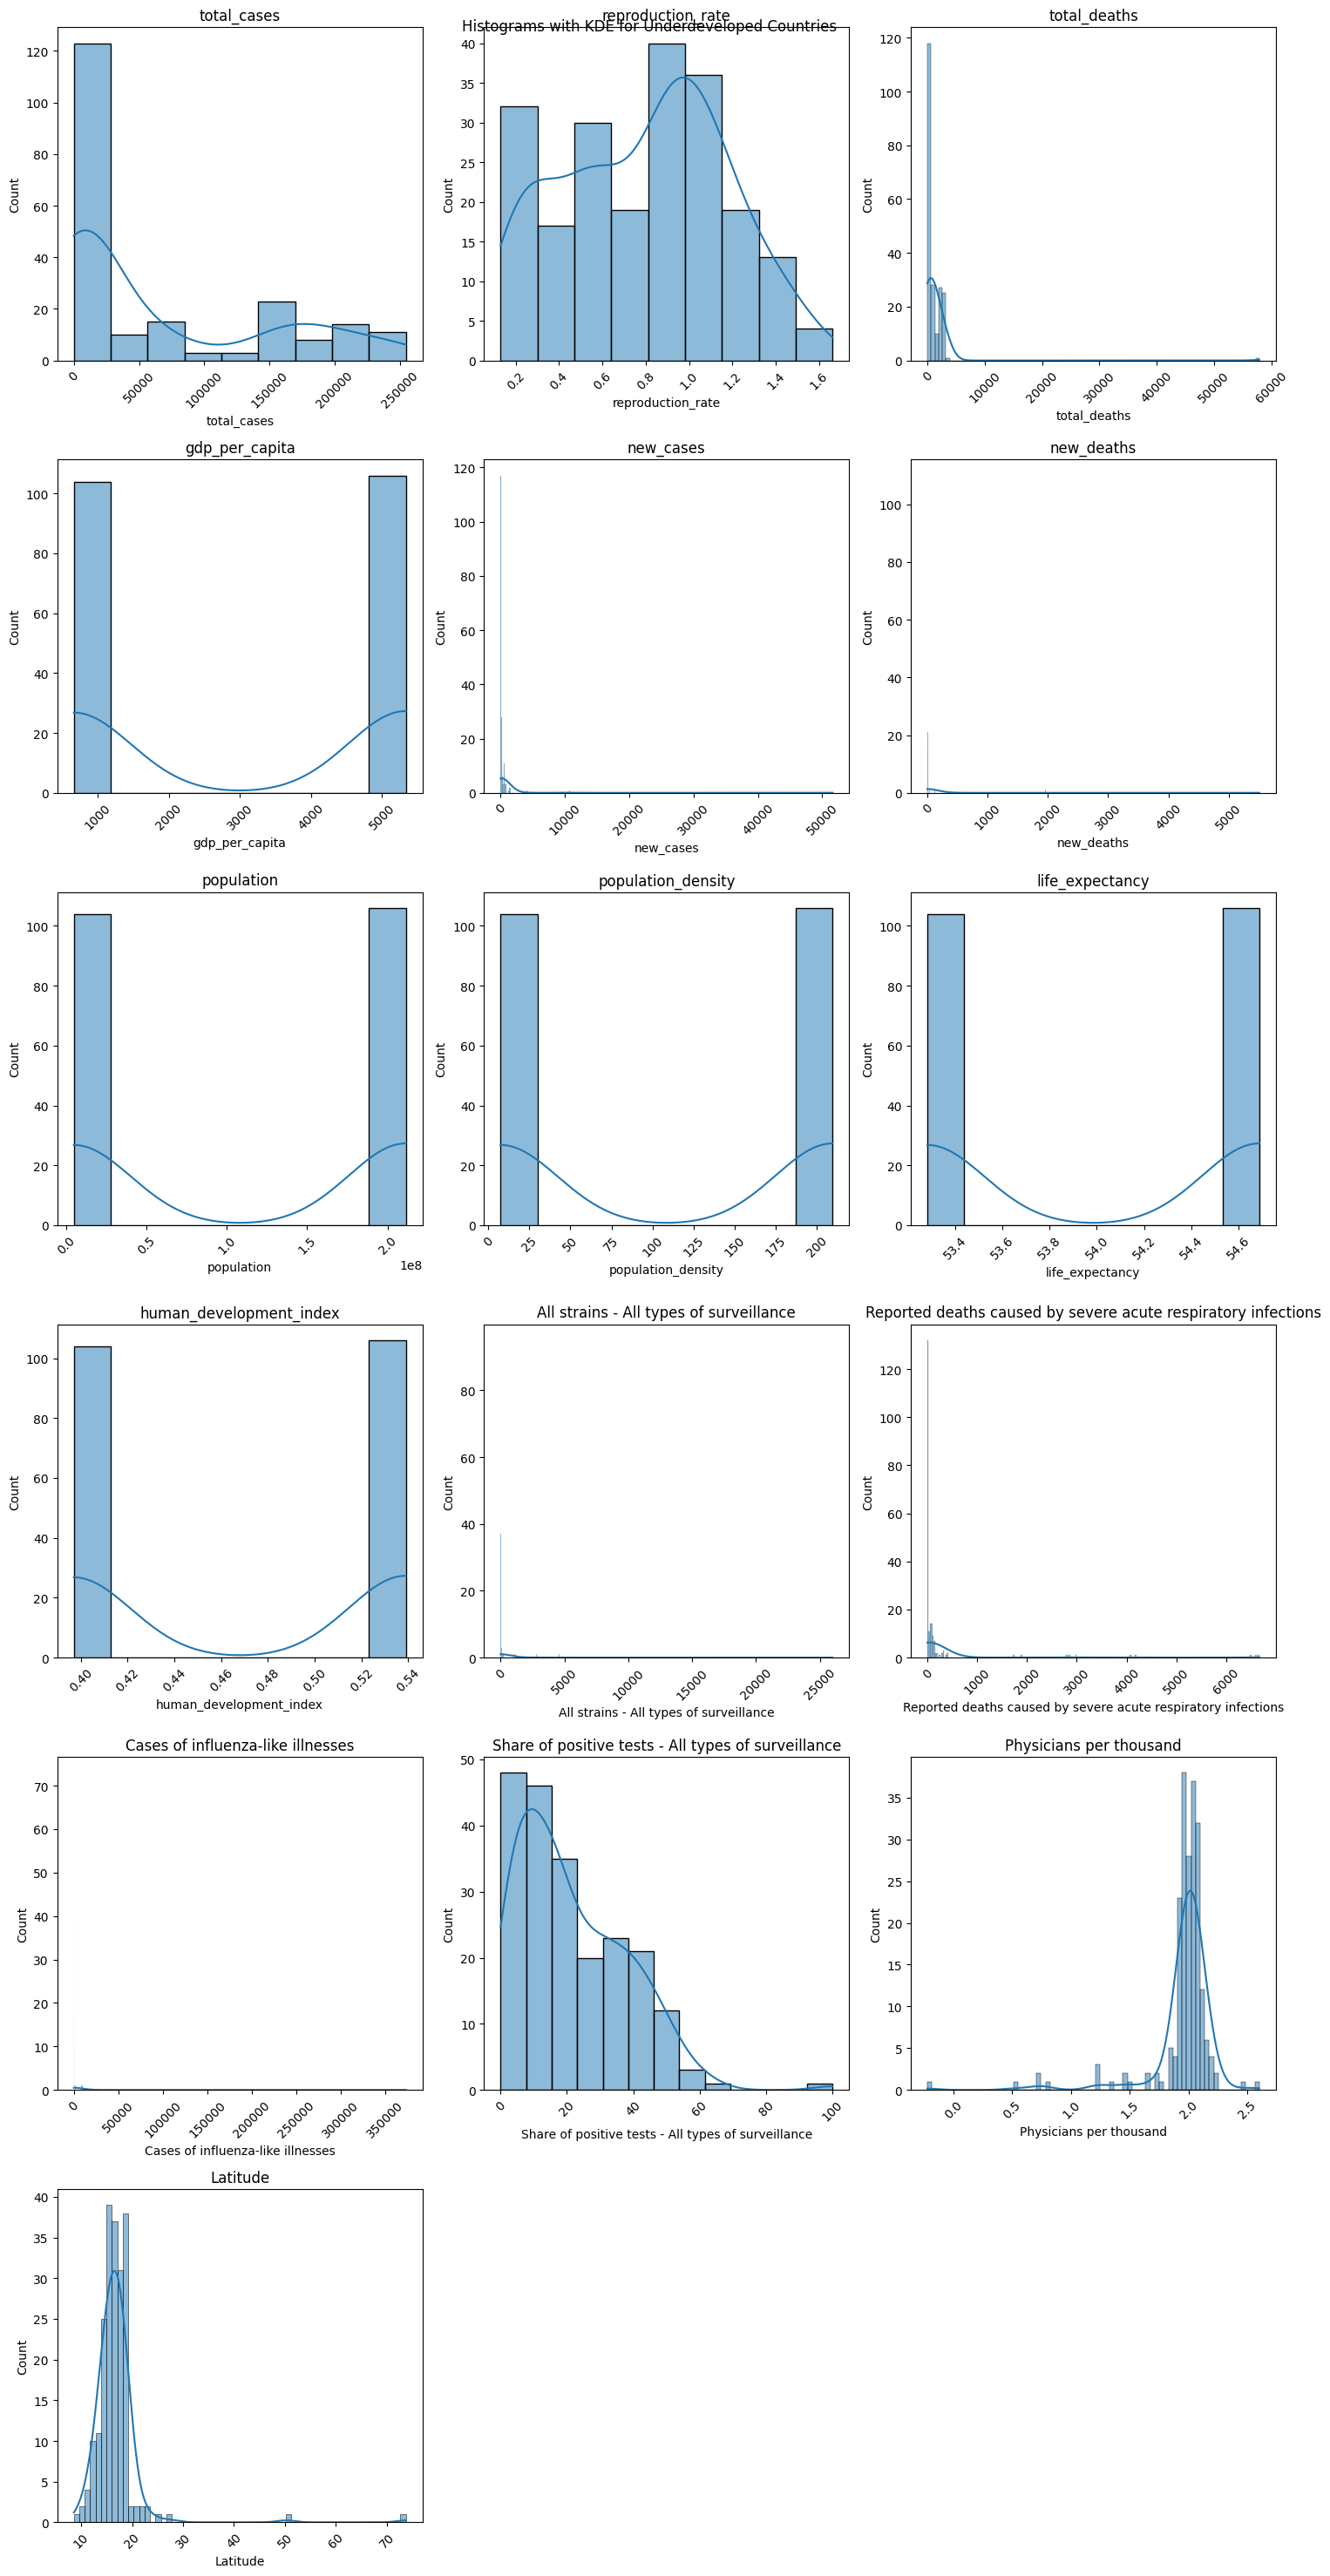

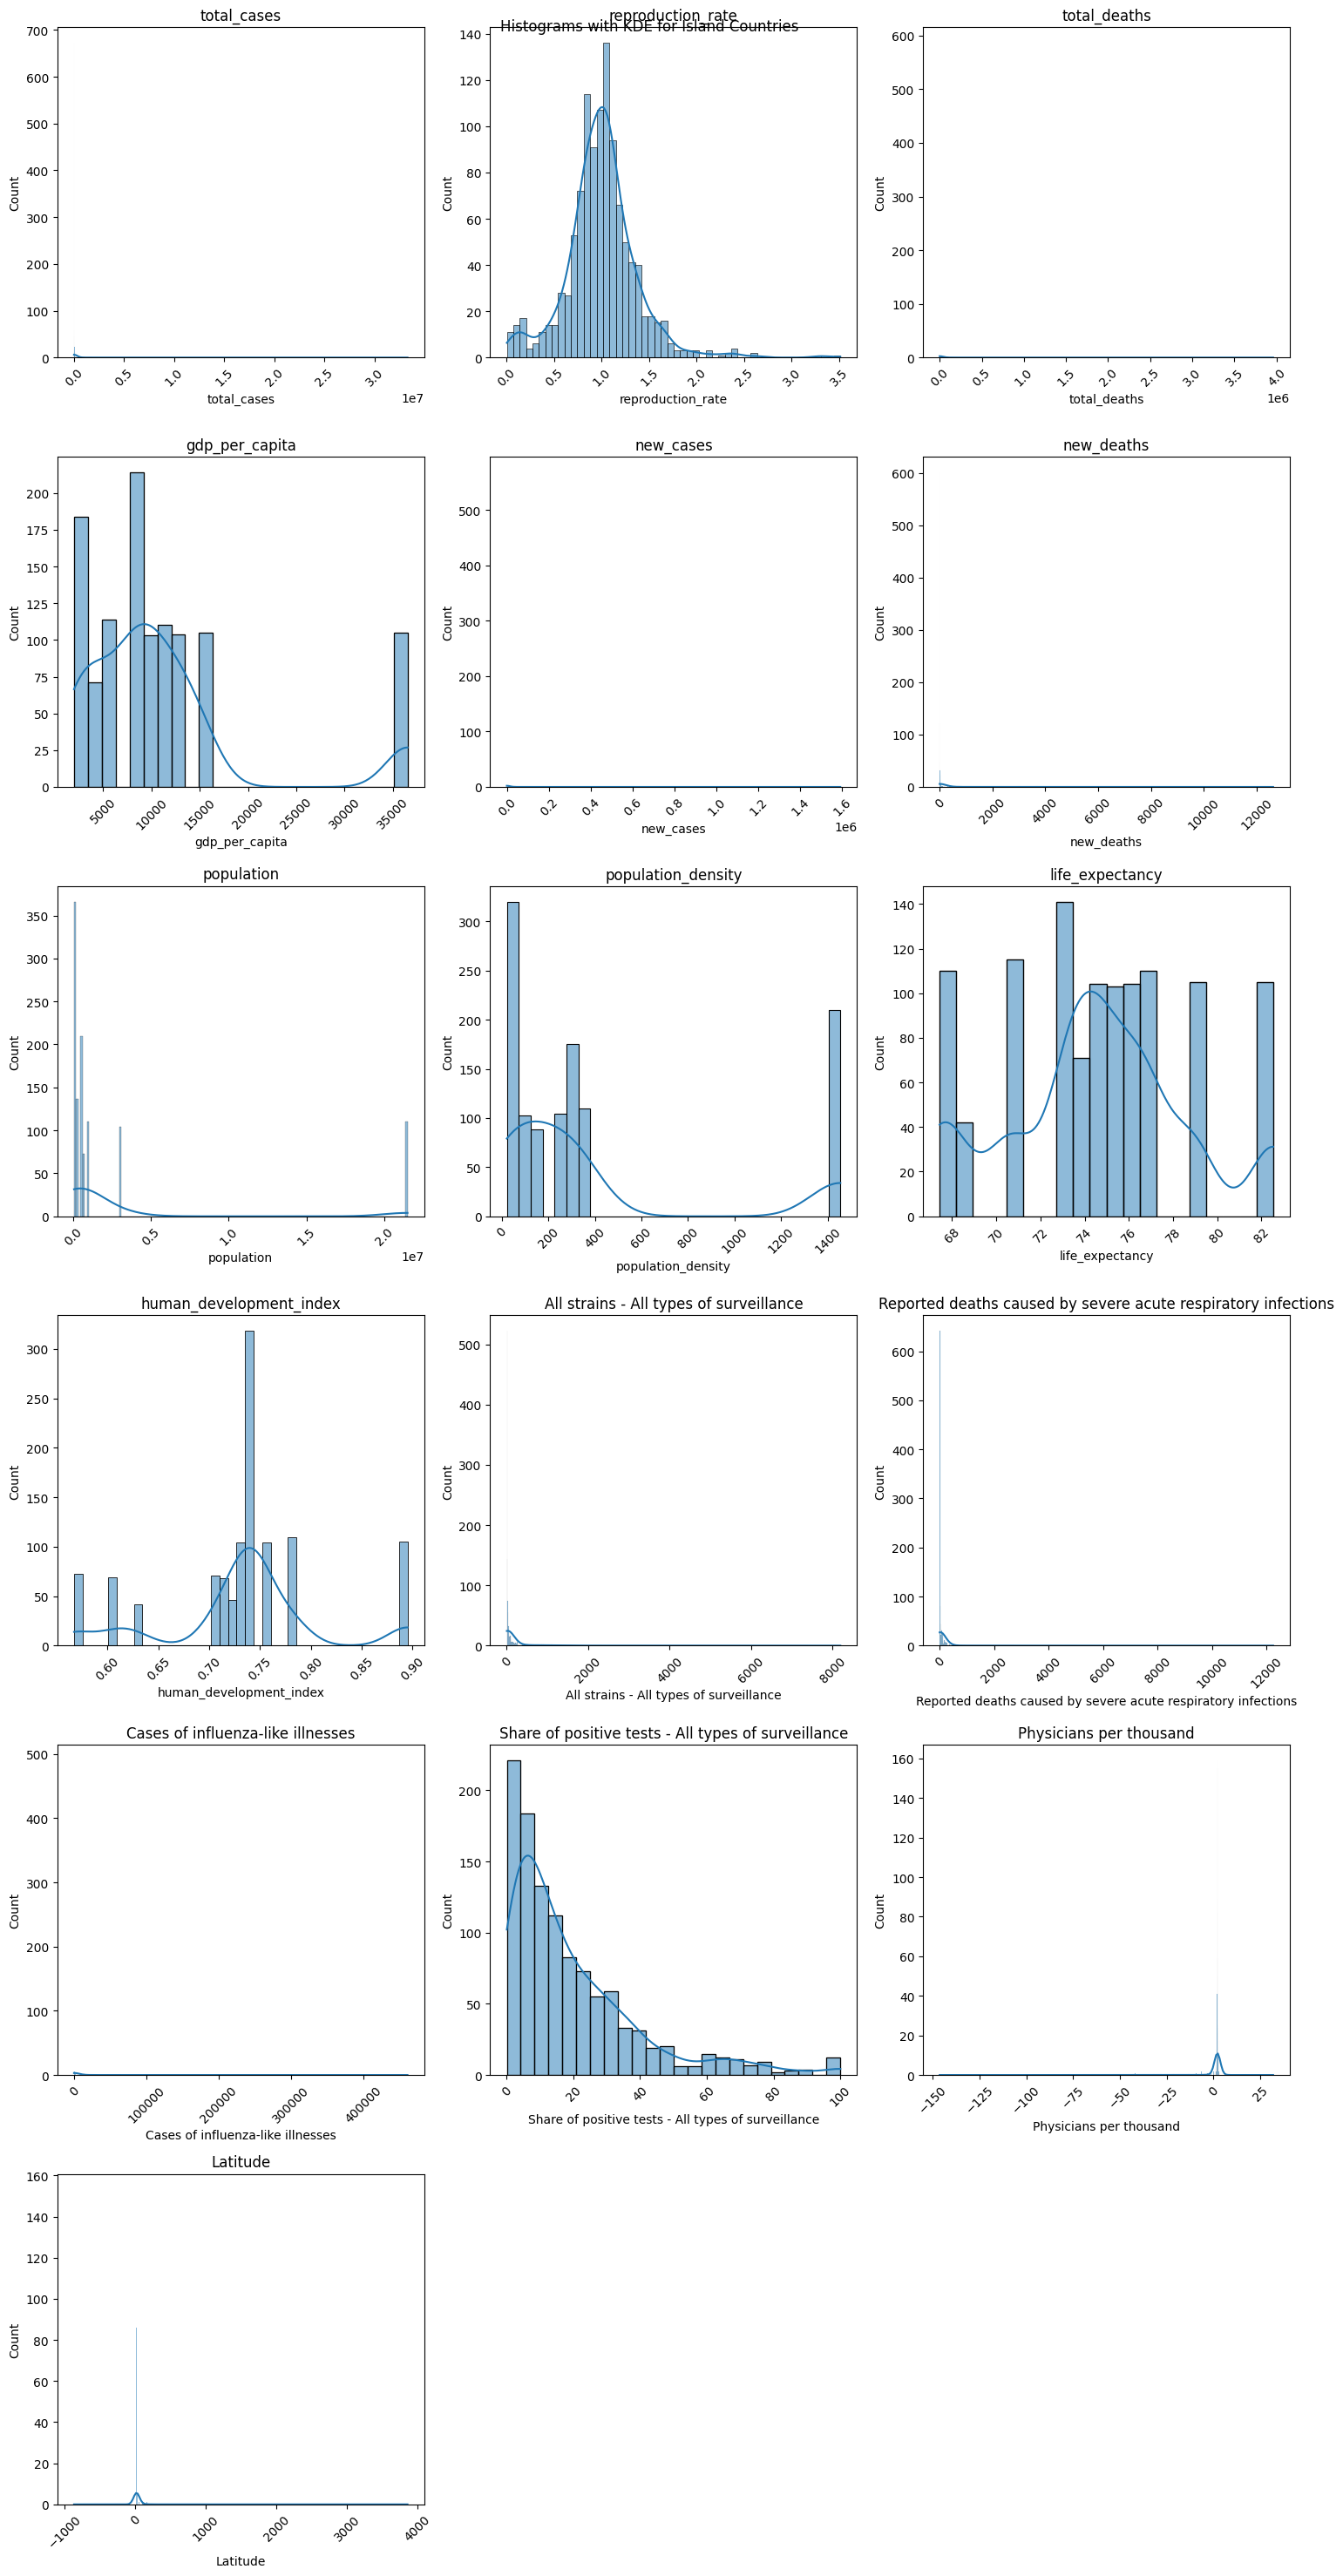

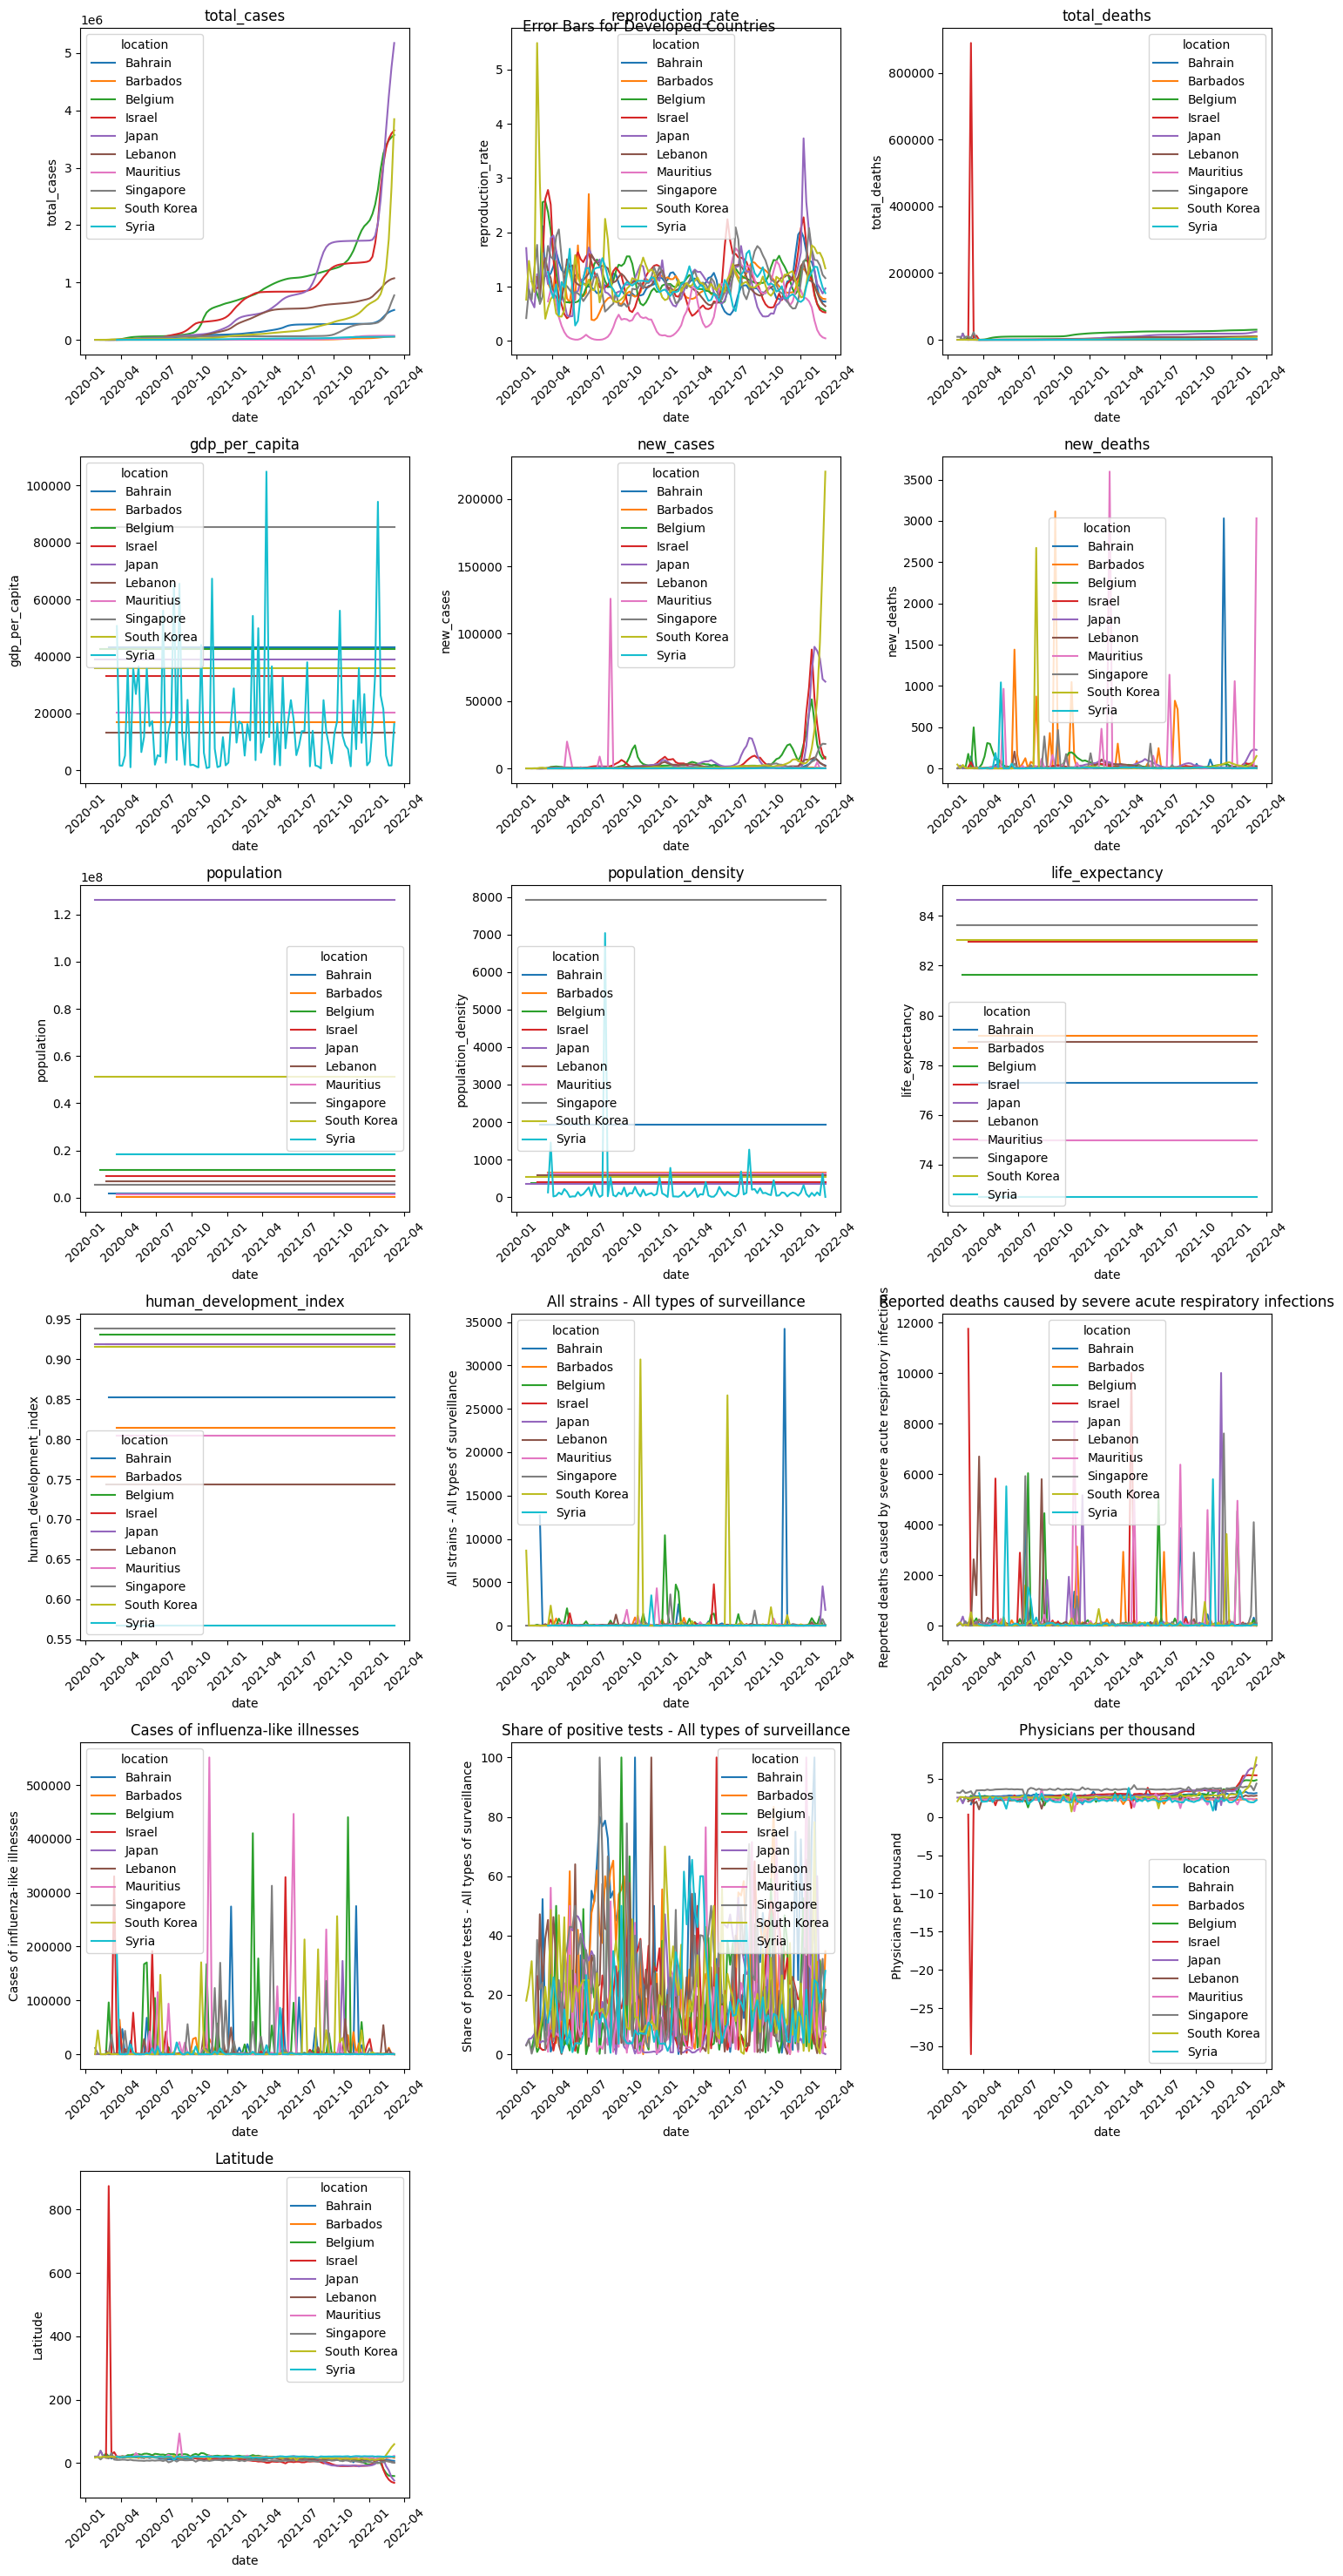

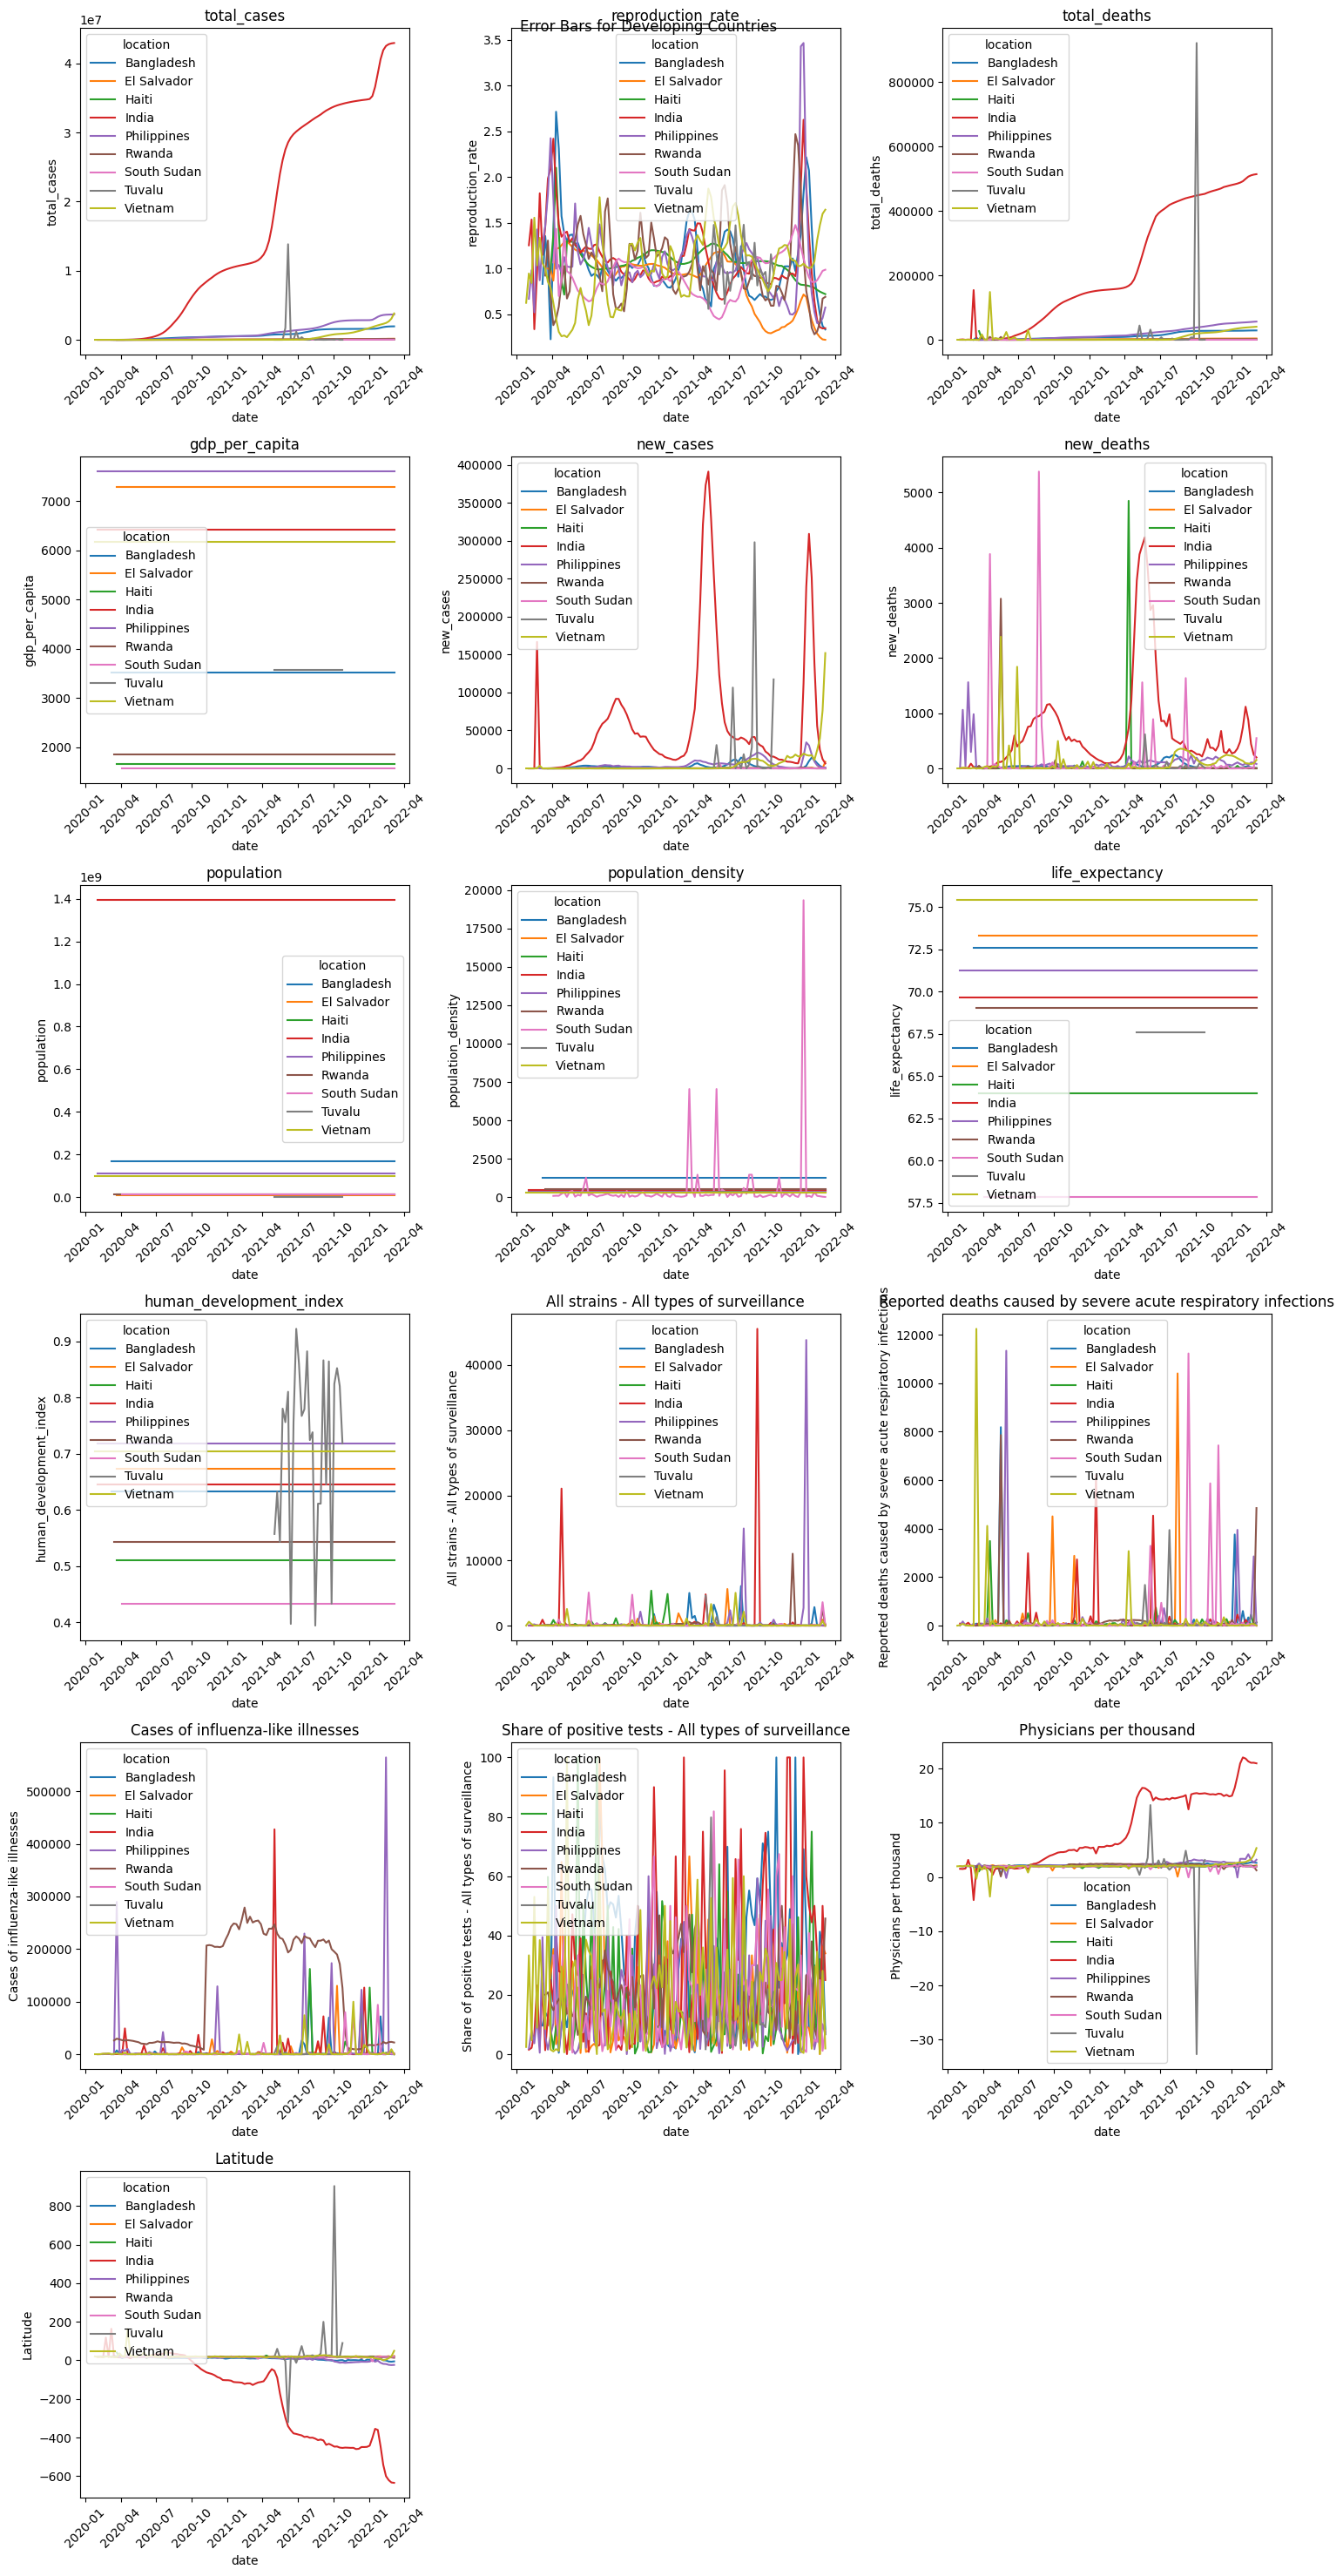

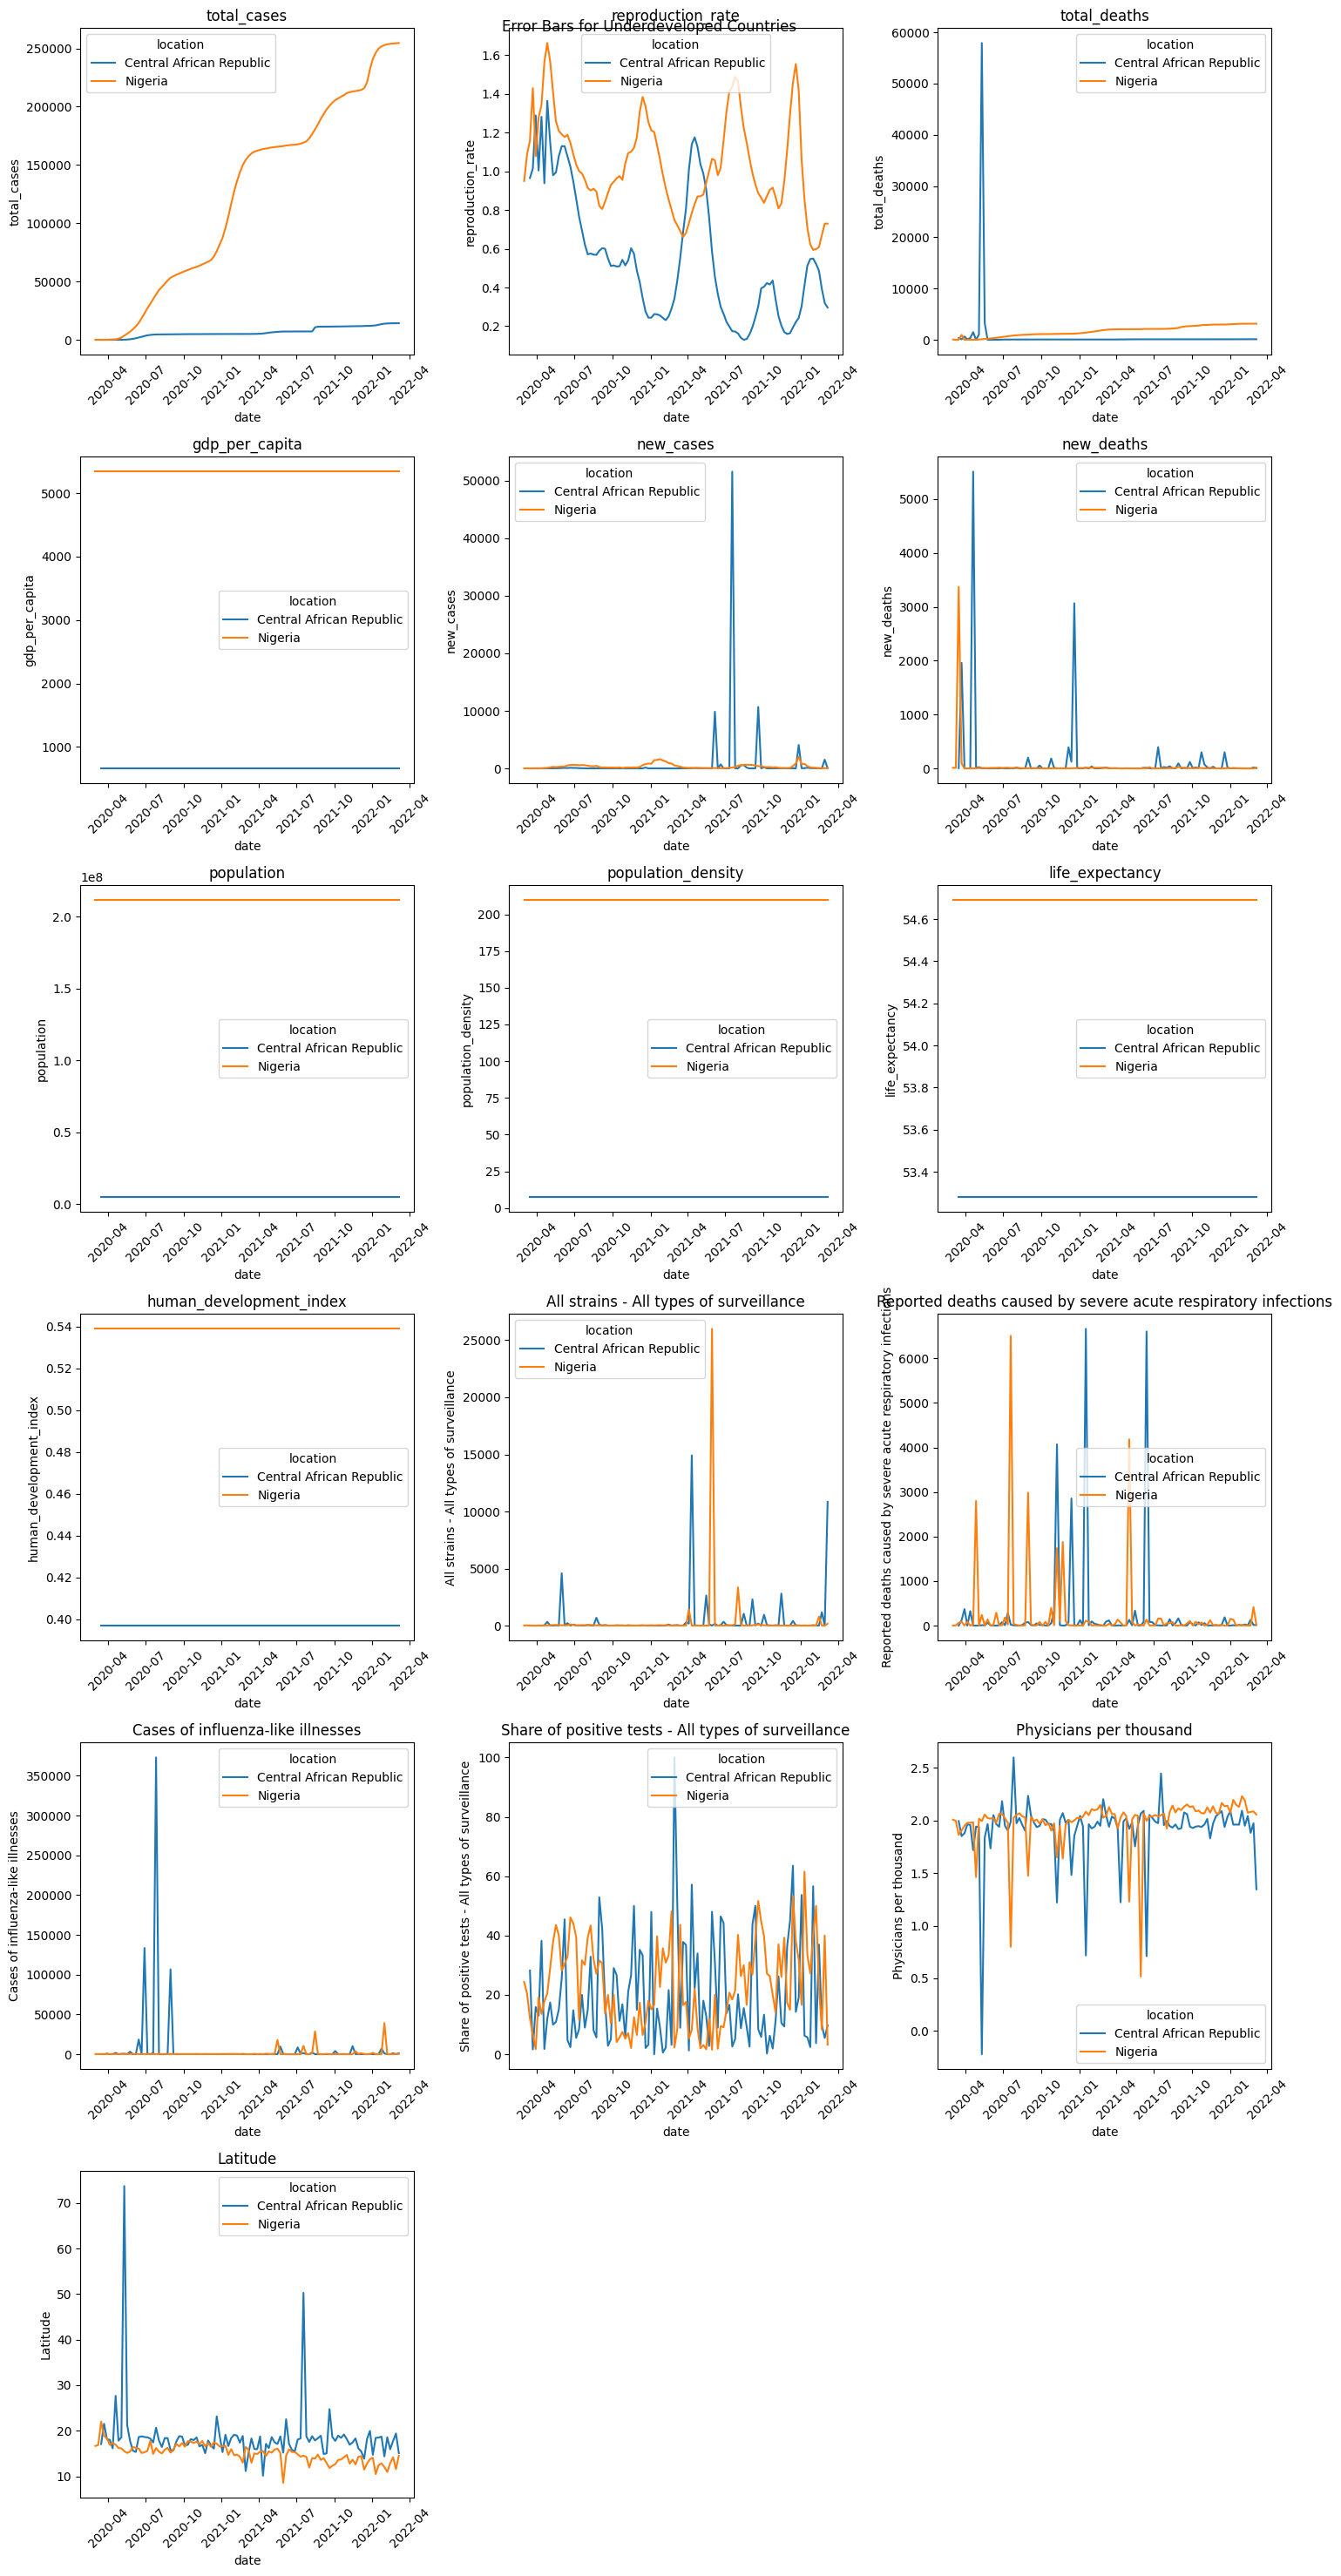

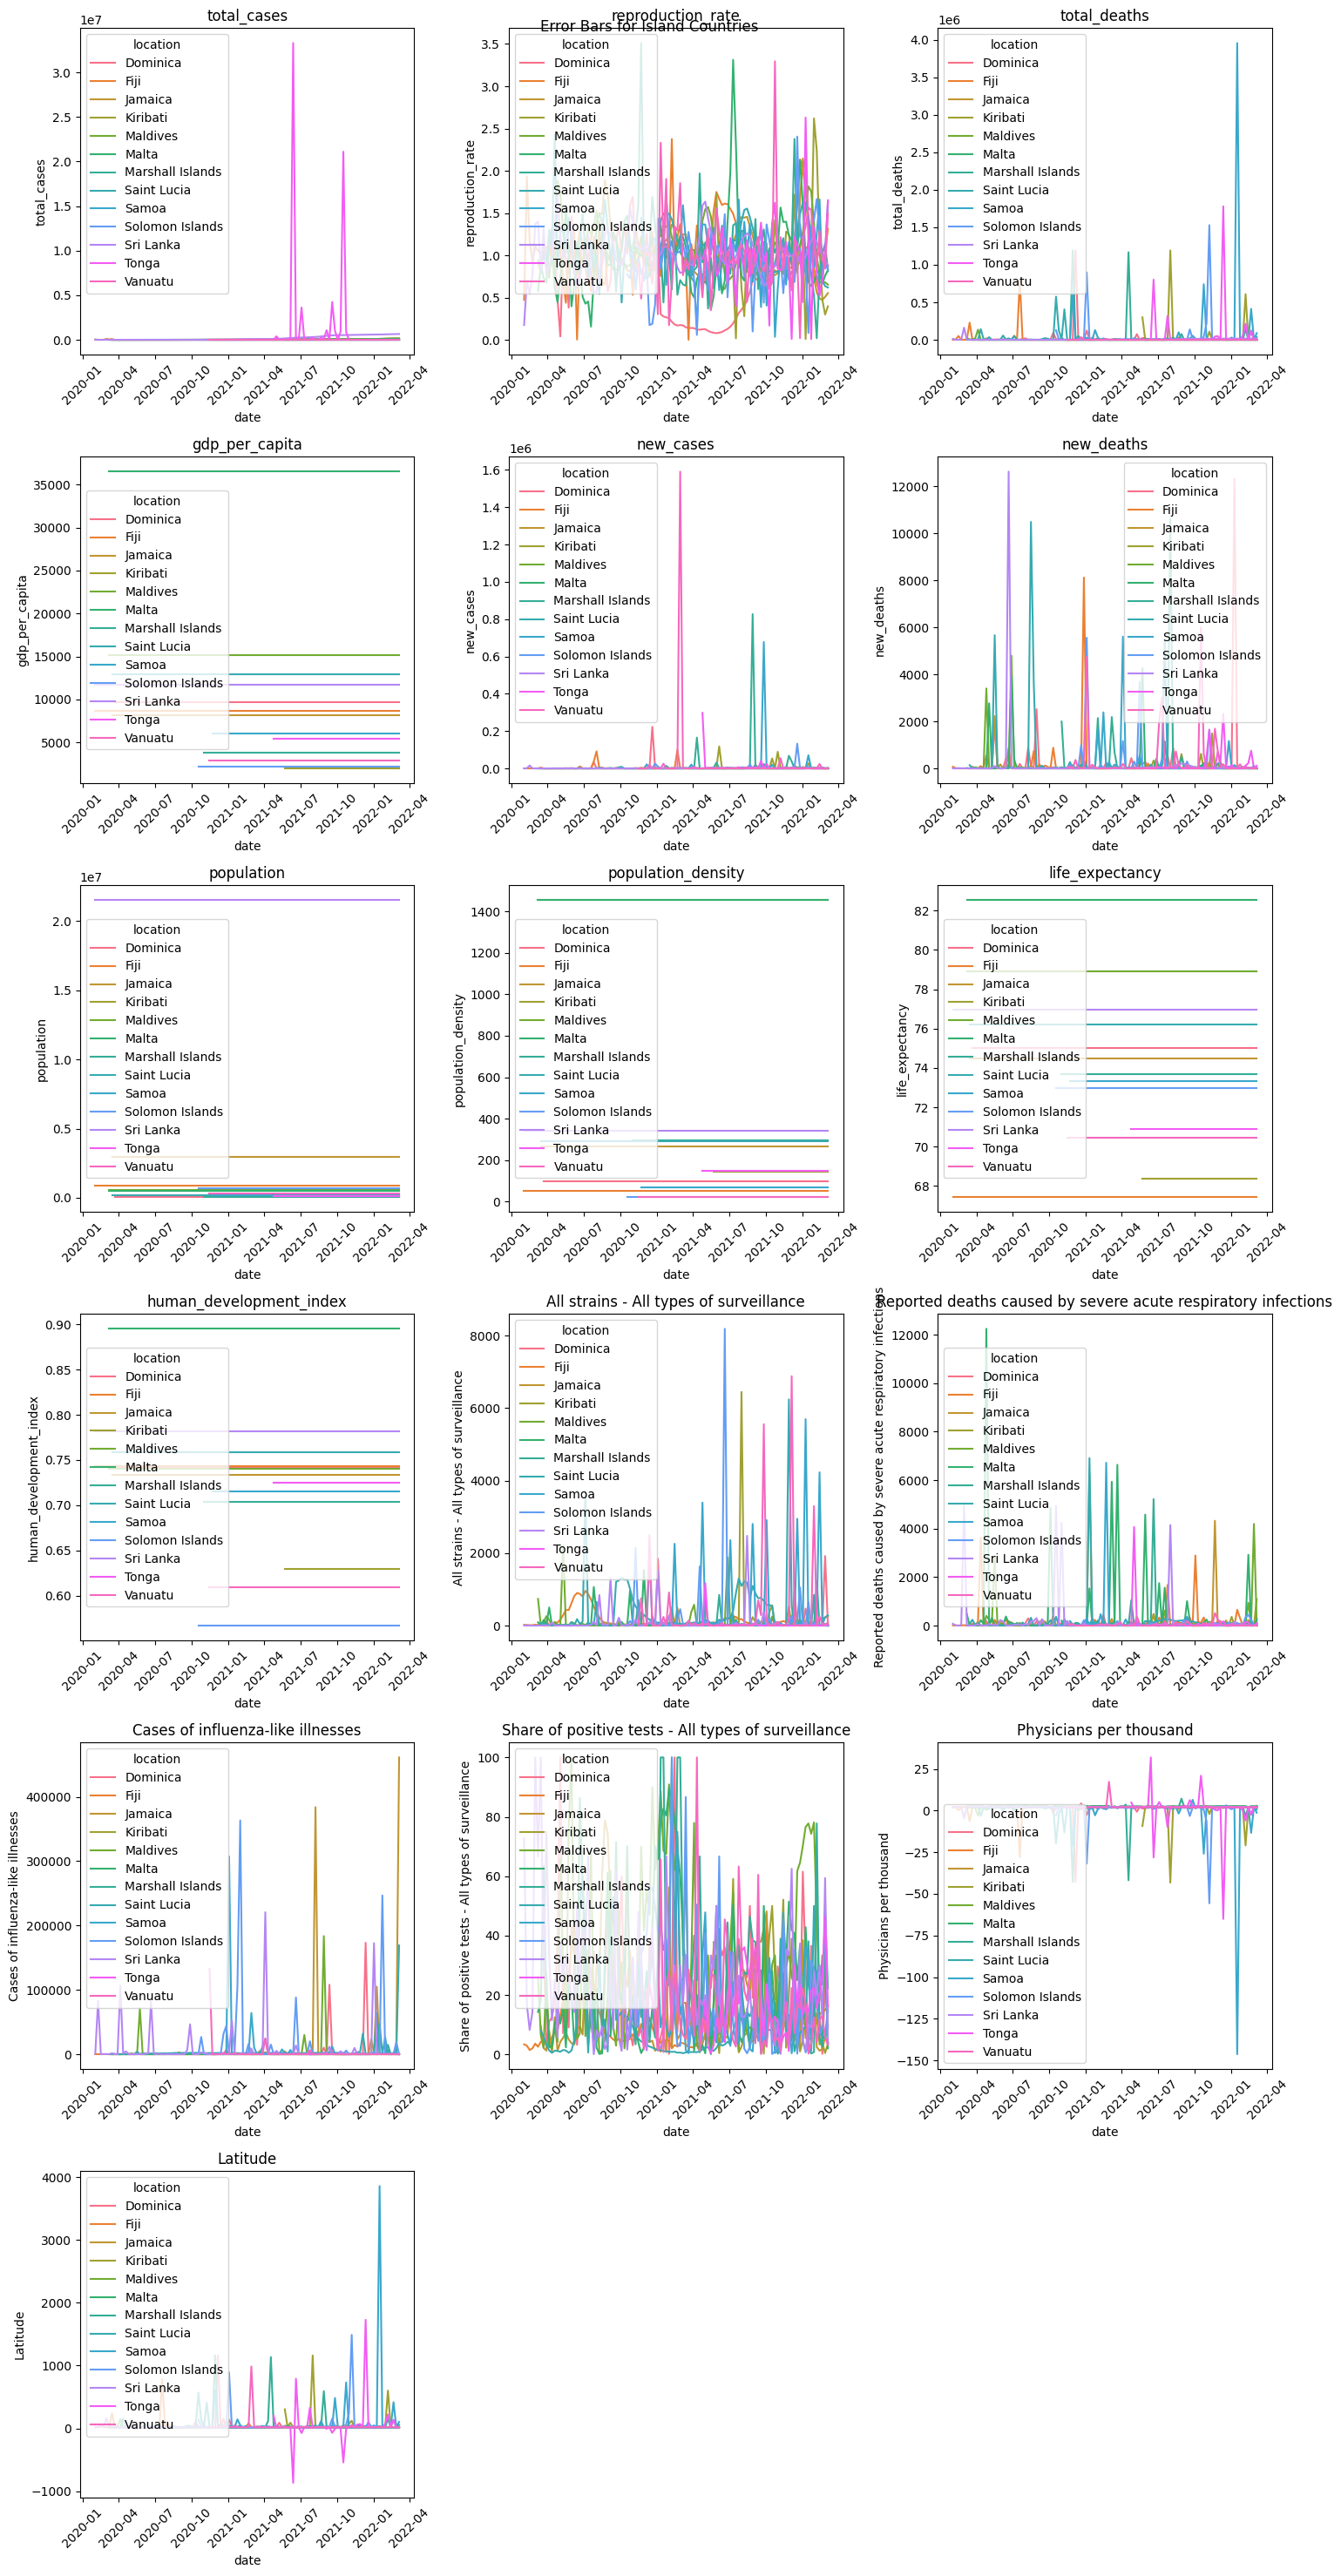

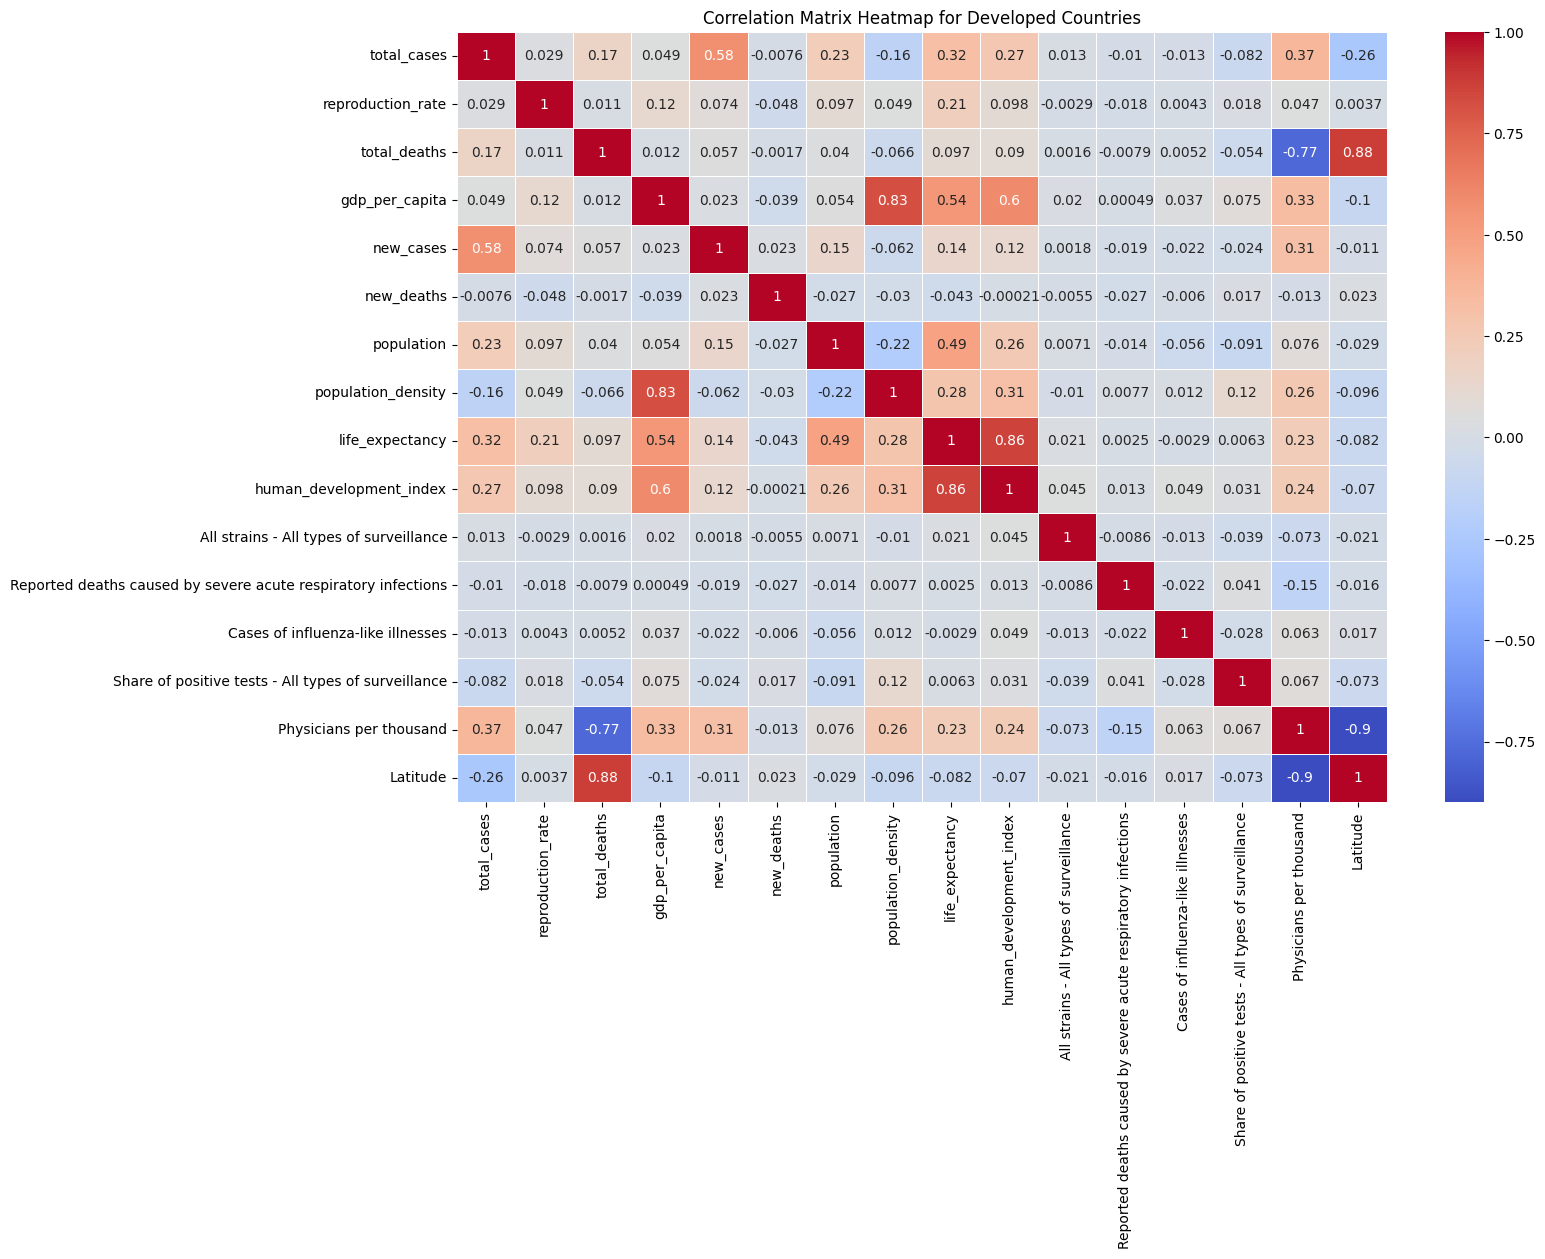

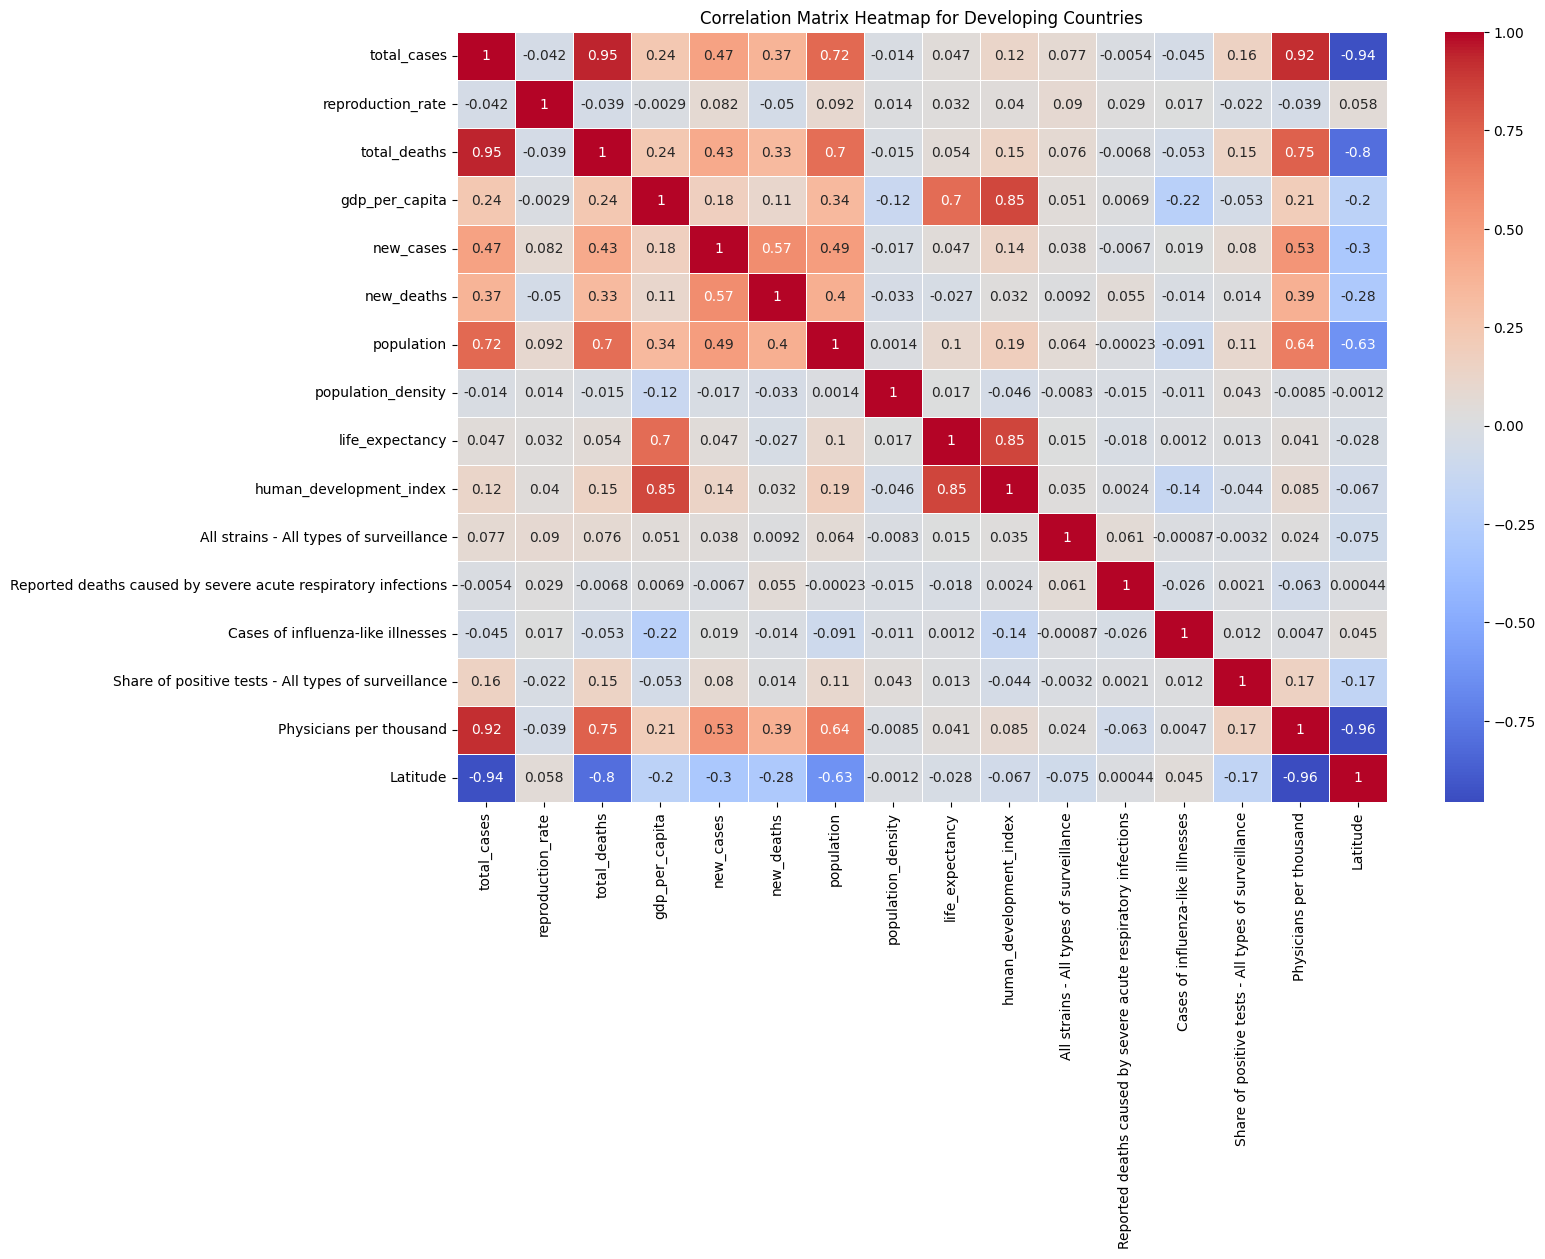

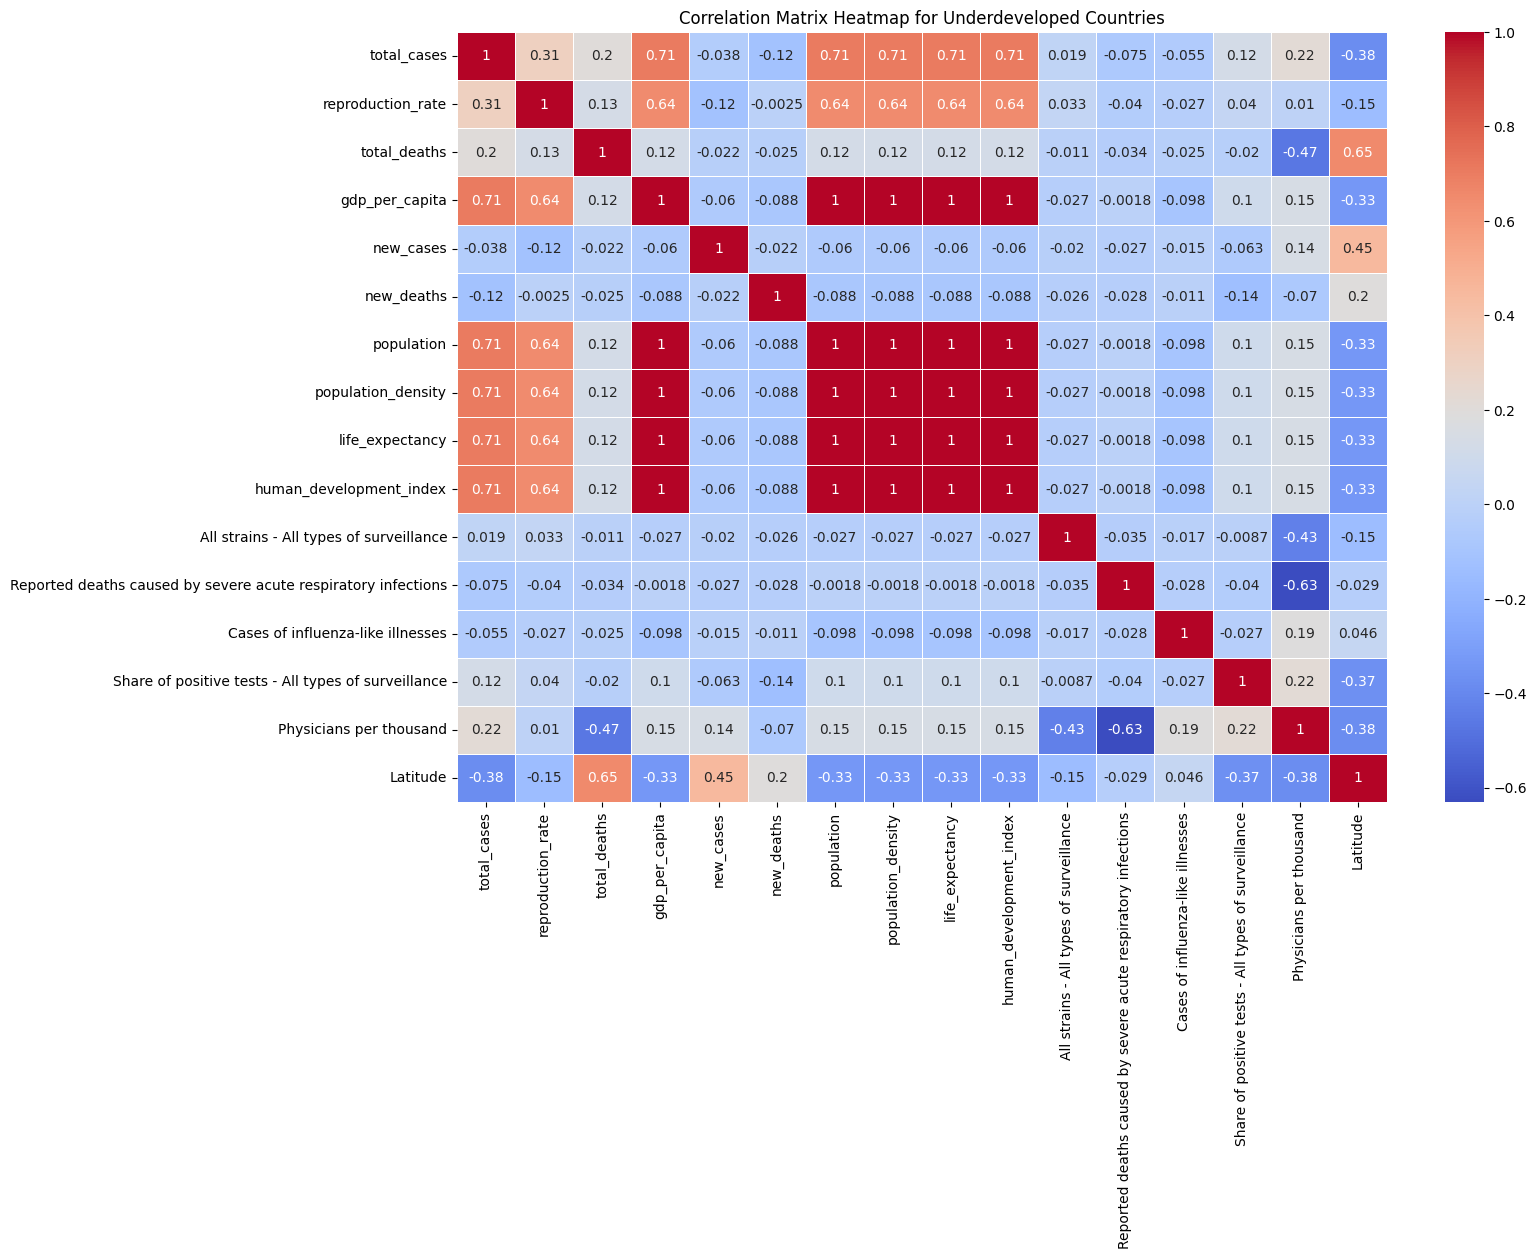

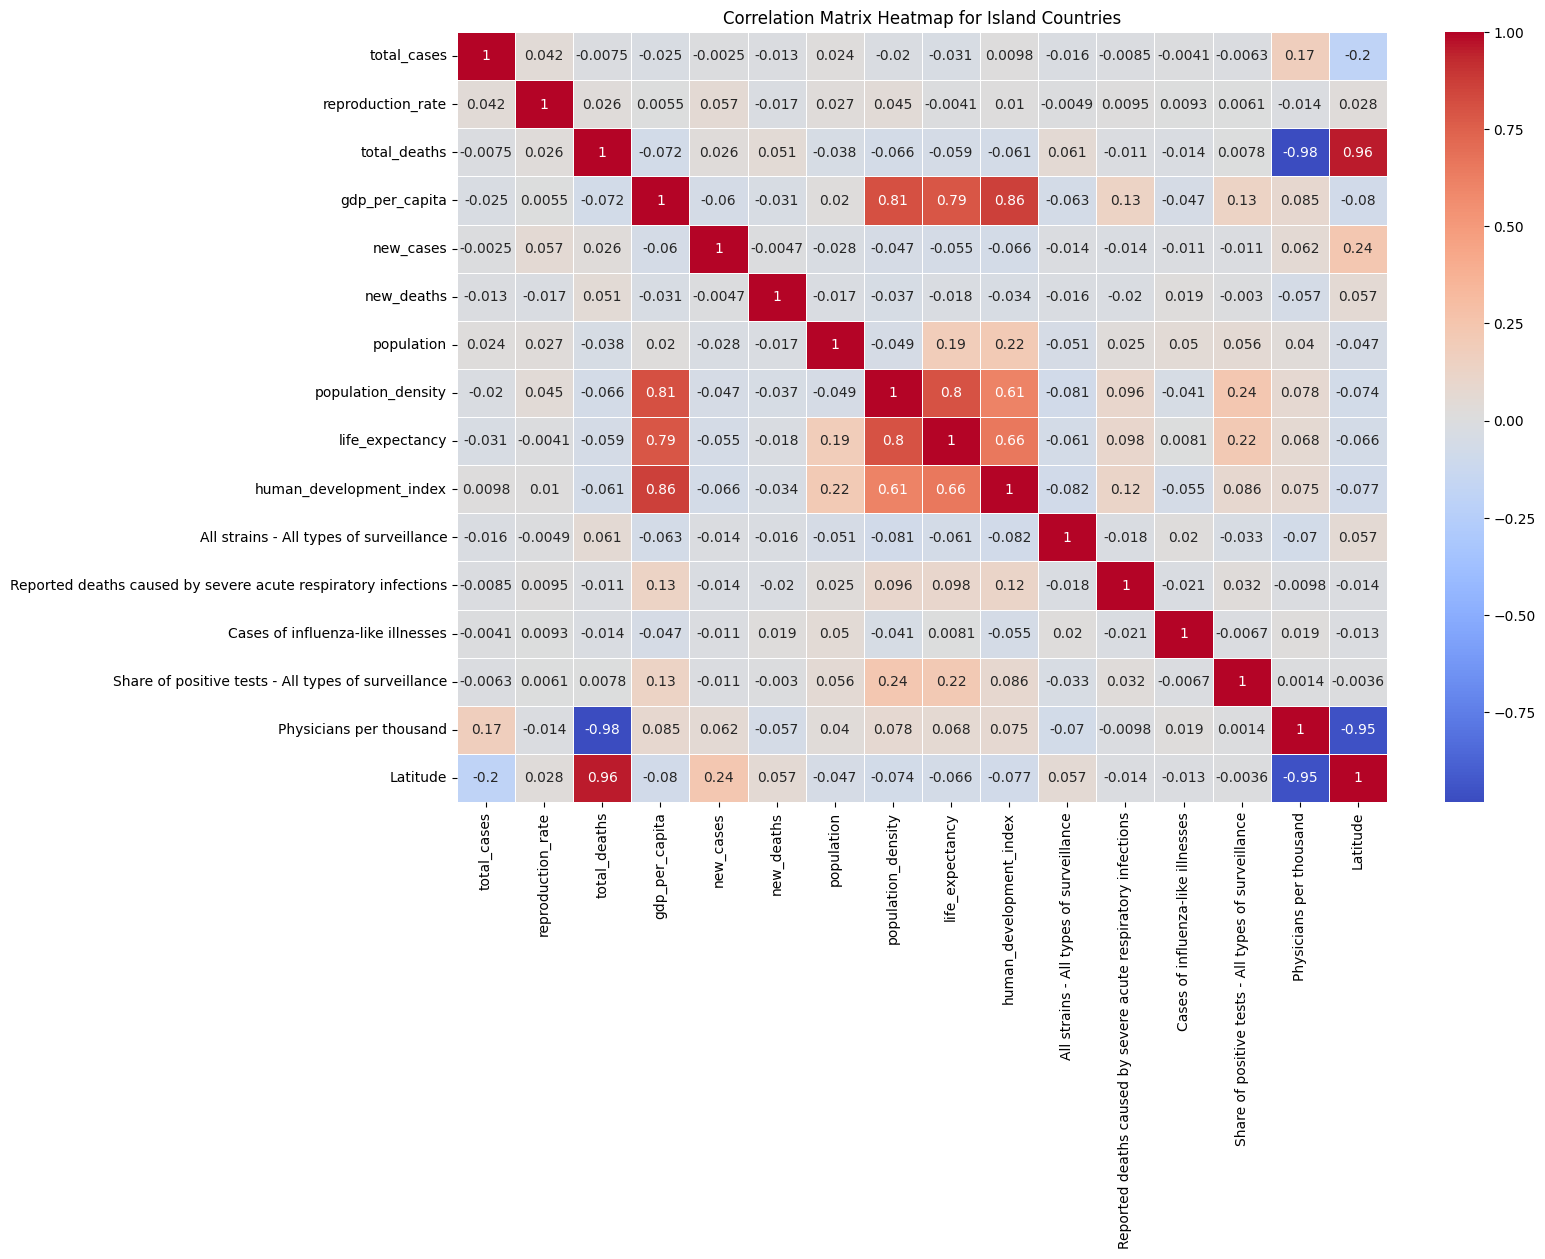

In [ ]:
# Ensure inline plotting
%matplotlib inline


# Function to create histograms with KDE
def plot_histograms_kde(data, title):
    if not data.empty:
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        n_cols = 3
        n_rows = int(np.ceil(len(numeric_cols) / n_cols))
        plt.figure(figsize=(n_cols * 5, n_rows * 5))
        for i, col in enumerate(numeric_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.histplot(data[col], kde=True)
            plt.title(col)
            plt.xticks(rotation=45)
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for {title}")

# Function to create multi-panel plots with error bars
def plot_error_bars(data, title):
    if not data.empty:
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        n_cols = 3
        n_rows = int(np.ceil(len(numeric_cols) / n_cols))
        plt.figure(figsize=(n_cols * 5, n_rows * 5))
        for i, col in enumerate(numeric_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.lineplot(x='date', y=col, hue='location', data=data)
            plt.title(col)
            plt.xticks(rotation=45)
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for {title}")

# Function to create heatmap of the correlation matrix
def plot_heatmap(data, title):
    if not data.empty:
        numeric_df = data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_df.corr()
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for {title}")

# Plot histograms with KDE for each category
plot_histograms_kde(developed_df, 'Histograms with KDE for Developed Countries')
plot_histograms_kde(developing_df, 'Histograms with KDE for Developing Countries')
plot_histograms_kde(underdeveloped_df, 'Histograms with KDE for Underdeveloped Countries')
plot_histograms_kde(island_df, 'Histograms with KDE for Island Countries')

# Plot error bars for each category
plot_error_bars(developed_df, 'Error Bars for Developed Countries')
plot_error_bars(developing_df, 'Error Bars for Developing Countries')
plot_error_bars(underdeveloped_df, 'Error Bars for Underdeveloped Countries')
plot_error_bars(island_df, 'Error Bars for Island Countries')

# Plot heatmaps for each category
plot_heatmap(developed_df, 'Correlation Matrix Heatmap for Developed Countries')
plot_heatmap(developing_df, 'Correlation Matrix Heatmap for Developing Countries')
plot_heatmap(underdeveloped_df, 'Correlation Matrix Heatmap for Underdeveloped Countries')
plot_heatmap(island_df, 'Correlation Matrix Heatmap for Island Countries')

<ipython-input-31-7914eb433804>:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


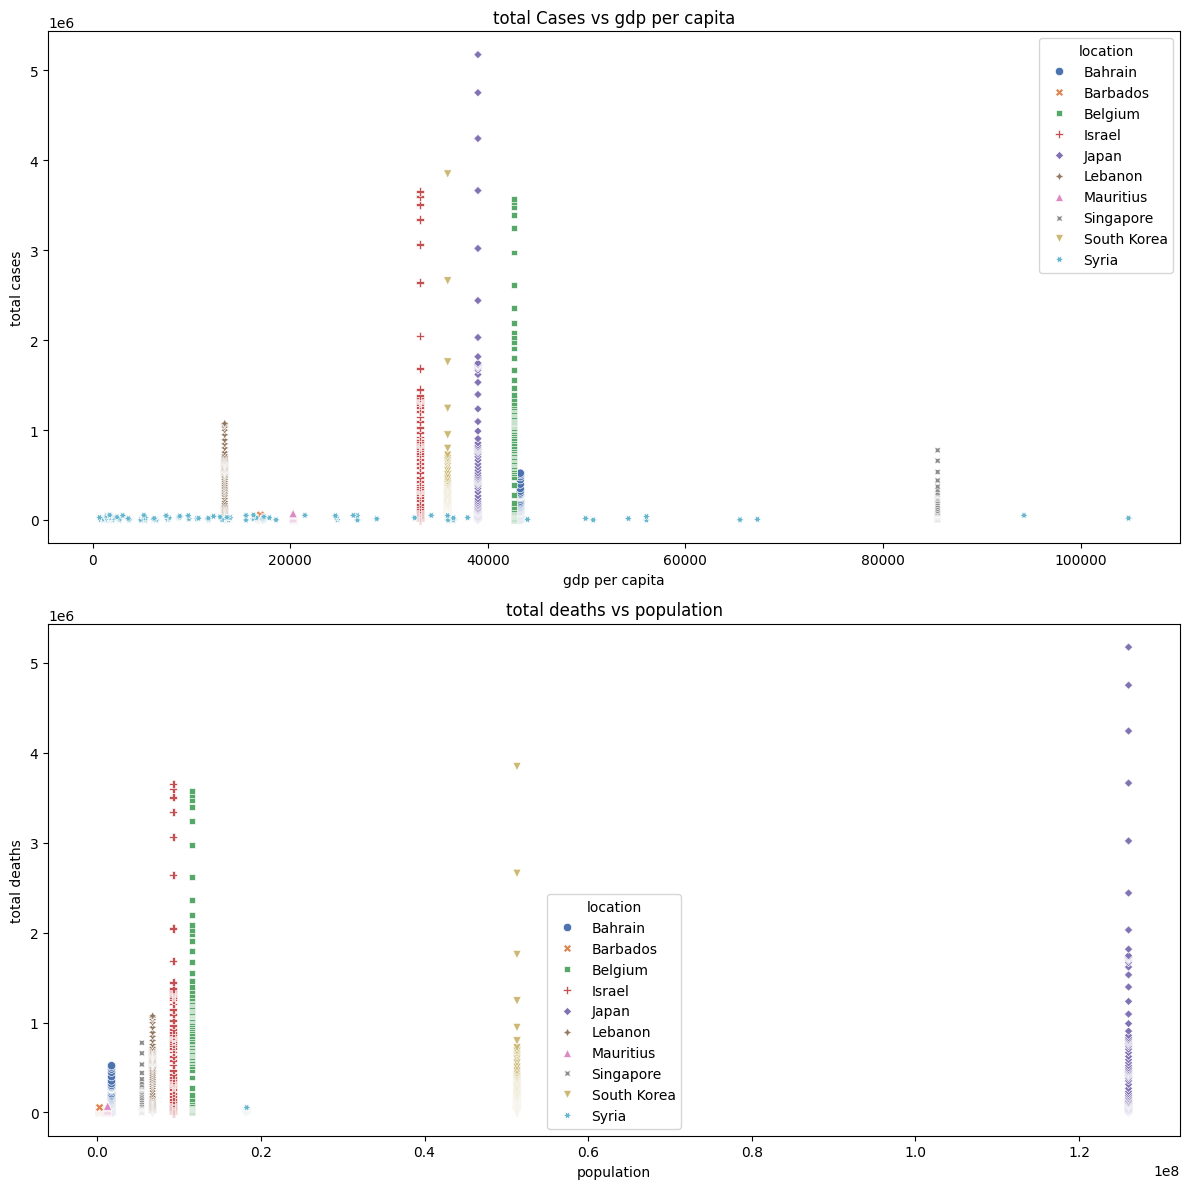

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
file_path = '/content/drive/MyDrive/FINAL PROJECT/final_cleaned_data.csv'
df = pd.read_csv(file_path)

# Filter the dataset for each category
developed_df = df[df['location'].isin(developed_countries)]
developing_df = df[df['location'].isin(developing_countries)]
underdeveloped_df = df[df['location'].isin(underdeveloped_countries)]
island_df = df[df['location'].isin(island_countries)]

# Filter the dataset to include only the necessary countries (optional step if not already done)
#necessary_countries = [...]  # List your necessary countries here
df = df[df['location'].isin(developed_countries)]

# Ensure the columns are named appropriately as per your dataset
# Example column names: 'Country', 'Total_Cases', 'GDP_per_Capita', 'Total_Deaths', 'Population', 'Group'
# If your actual column names are different, please adjust accordingly

# Plotting
def plot_multi_panel(dataframe):
    # Set up the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

    # First plot: Total Cases vs GDP per Capita
    sns.scatterplot(data=dataframe, x='gdp_per_capita', y='total_cases', hue='location', style='location', ax=axes[0], palette='deep')
    axes[0].set_title('total Cases vs gdp per capita')
    axes[0].set_xlabel('gdp per capita')
    axes[0].set_ylabel('total cases')

    # Second plot: Total Deaths vs Population
    sns.scatterplot(data=dataframe, x='population', y='total_cases', hue='location', style='location', ax=axes[1], palette='deep')
    axes[1].set_title('total deaths vs population')
    axes[1].set_xlabel('population')
    axes[1].set_ylabel('total deaths')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Apply the function to your dataframe
plot_multi_panel(df)


<ipython-input-32-9ff7588e6e10>:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


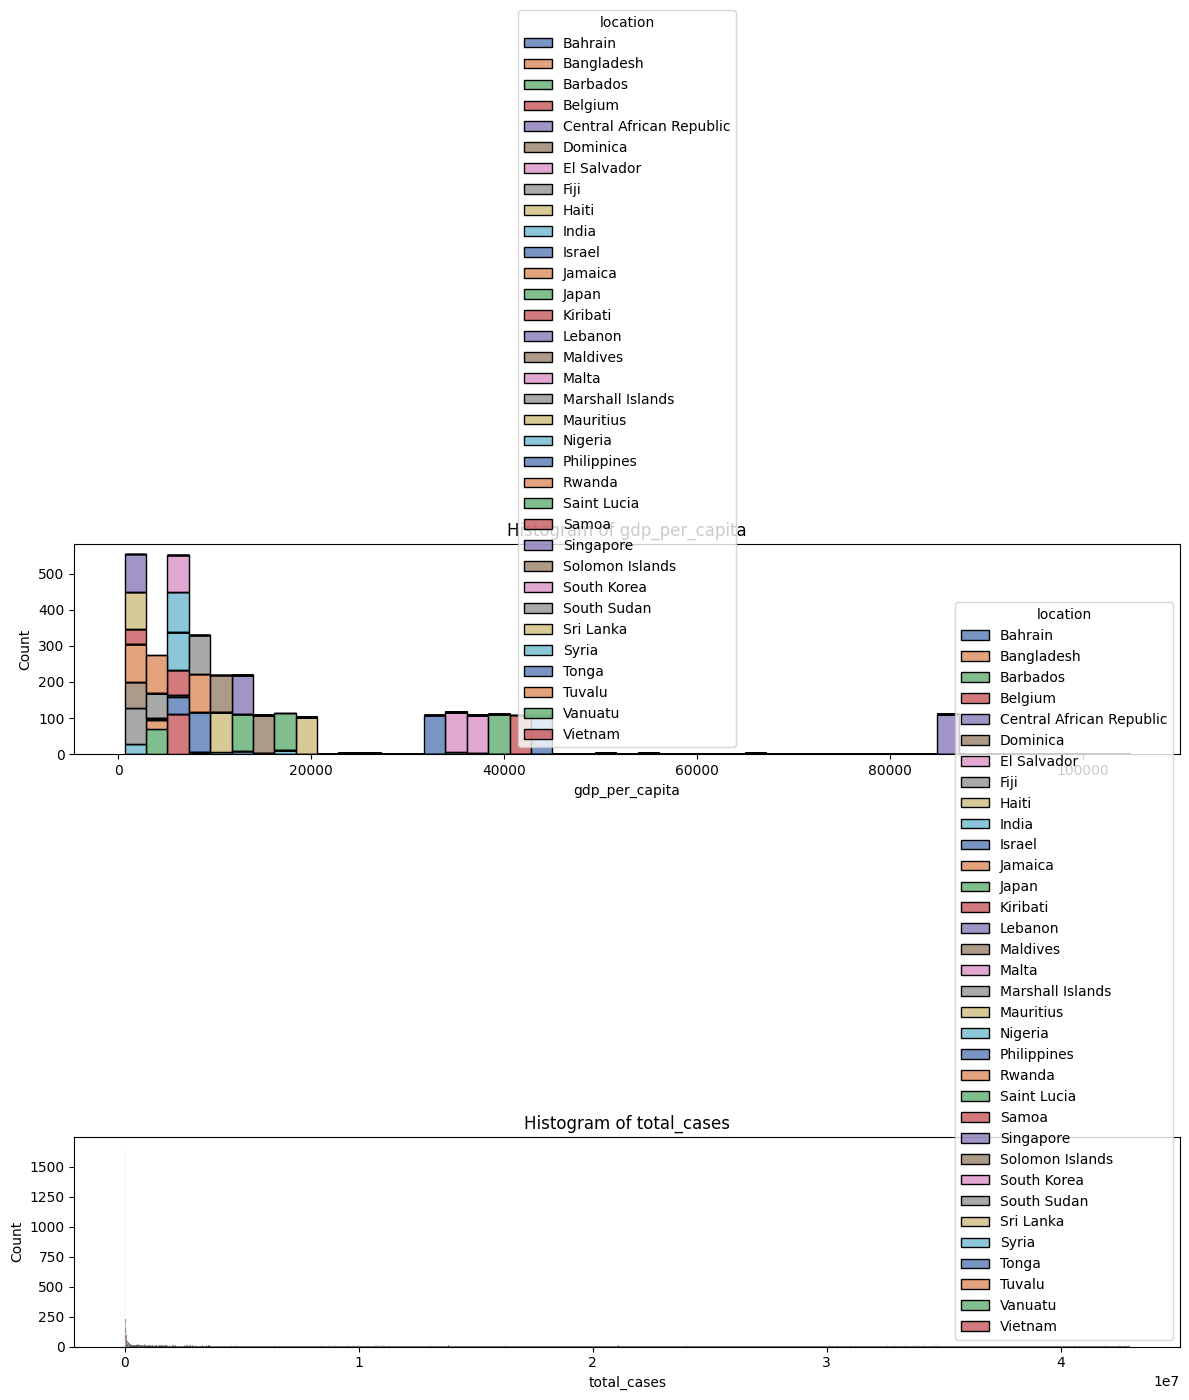

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
file_path = '/content/drive/MyDrive/FINAL PROJECT/final_cleaned_data.csv'
df = pd.read_csv(file_path)

# Define country lists for each category
developed_countries = ['Singapore', 'Bahrain', 'Barbados', 'Mauritius', 'Lebanon', 'South Korea', 'Syria', 'Israel', 'Belgium', 'Japan']
developing_countries = ['Bangladesh', 'Rwanda', 'South Sudan', 'India', 'Haiti', 'Tuvalu', 'Philippines', 'Vietnam', 'El Salvador']
underdeveloped_countries = ['Nigeria', 'Central African Republic']
island_countries = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Saint Lucia', 'Sri Lanka']

# Filter the dataset for each category
developed_df = df[df['location'].isin(developed_countries)]
developing_df = df[df['location'].isin(developing_countries)]
underdeveloped_df = df[df['location'].isin(underdeveloped_countries)]
island_df = df[df['location'].isin(island_countries)]


# Filter the dataset to include only the necessary countries (optional step if not already done)
necessary_countries = developed_countries + developing_countries + underdeveloped_countries + island_countries
df = df[df['location'].isin(necessary_countries)]

# Ensure the columns are named appropriately as per your dataset
# Example column names: 'Country', 'Total_Cases', 'GDP_per_Capita', 'Total_Deaths', 'Population', 'Group'
# If your actual column names are different, please adjust accordingly

# Plotting function for multi-panel histograms
def plot_multi_panel_histogram(dataframe, column1, column2):
    # Set up the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

    # First plot: Histogram of column1
    sns.histplot(data=dataframe, x=column1, hue='location', multiple='stack', ax=axes[0], palette='deep')
    axes[0].set_title(f'Histogram of {column1}')
    axes[0].set_xlabel(column1)
    axes[0].set_ylabel('Count')

    # Second plot: Histogram of column2
    sns.histplot(data=dataframe, x=column2, hue='location', multiple='stack', ax=axes[1], palette='deep')
    axes[1].set_title(f'Histogram of {column2}')
    axes[1].set_xlabel(column2)
    axes[1].set_ylabel('Count')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Apply the function to your dataframe
plot_multi_panel_histogram(df, 'gdp_per_capita', 'total_cases')
